In [1]:
!pip install wfdb --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 3.9 MB/s eta 0:00:00


# preprocessing

In [2]:
import wfdb
from scipy.signal import butter, filtfilt
import numpy as np
from scipy.signal import resample
from re import S
import os

In [3]:
def bandpass_filter(signal, fs=250, lowcut=0.5,  highcut=15.0,  order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)
    
def smooth_signal(data, window_size=5):
    window = np.ones(window_size) / window_size
    smoothed = np.convolve(data, window, mode='same')
    return smoothed
def normalize_signal(data):
    return (data - np.mean(data)) / np.std(data)

In [4]:

def resample_signal(signal, original_fs, target_fs):
    num_samples = int(len(signal) * target_fs / original_fs)
    resampled_signal = resample(signal, num_samples)
    return resampled_signal
def adjust_annotations(samples, original_fs, target_fs):
    scale = target_fs / original_fs
    if isinstance(samples, (list, np.ndarray)):
        return (np.array(samples) * scale).astype(int)
    else:
        return int(samples * scale)

# Detection

In [5]:
def predict_Unet(signal, model, fs=250, window_size=240):
    model.eval()
    signal = signal[:len(signal) - (len(signal) % window_size)]  # crop to multiple of window_size
    signal = normalize_signal(smooth_signal(bandpass_filter(signal, fs=fs)))
    if fs != 250:
        signal = resample_signal(signal, original_fs=fs, target_fs=250)
        fs = fs
    signal = signal.reshape(1, 1, -1)  # (1, 1, L)

    segments = []
    predictions = []

    for i in range(0, signal.shape[2] - window_size + 1, window_size):
        window = signal[:, :, i:i+window_size]
        segments.append(window)

    with torch.no_grad():
        for window in segments:
            window = torch.tensor(window, dtype=torch.float32).to(device)
            output = model(window)  # (1, C, L)
            pred = torch.argmax(output, dim=1).cpu().numpy()[0]  # (L,)
            predictions.append(pred)

    full_prediction = np.concatenate(predictions)
    return full_prediction, segments, predictions

In [6]:
def predict_keras(signal, model, fs=250, window_size=240):
    
    signal = signal[:len(signal) - (len(signal) % window_size)]  
    signal = normalize_signal(smooth_signal(bandpass_filter(signal, fs=fs)))
    
    target_fs = 250
    if fs != target_fs:
        signal = resample_signal(signal, original_fs=fs, target_fs=target_fs)
    
    signal = signal.reshape(1, 1, -1)  # (1, 1, L)
    
    segments = []
    predictions = []
    
    for i in range(0, signal.shape[2] - window_size + 1, window_size):
        window = signal[:, :, i:i+window_size]
        segments.append(window)
        
        output = model.predict(window, verbose=0)  # (1, 240, 4)
        pred = np.argmax(output, axis=-1)[0]  # (240,)
        predictions.append(pred)
    
    full_prediction = np.concatenate(predictions)
    return full_prediction, segments, predictions

In [7]:
def get_wave_boundaries(predicted_labels):
    wave_types = {1: 'P', 2: 'QRS', 3: 'T'}
    wave_boundaries = {k: [] for k in wave_types.values()}

    current_class = None
    start = None

    for i, label in enumerate(predicted_labels):
        if label in wave_types:
            if current_class is None:
                current_class = label
                start = i
            elif label != current_class:
                wave_boundaries[wave_types[current_class]].append((start, i-1))
                current_class = label
                start = i
        else:

            if current_class is not None:
                wave_boundaries[wave_types[current_class]].append((start, i-1))
                current_class = None
                start = None

    # Handle last segment
    if current_class is not None:
        wave_boundaries[wave_types[current_class]].append((start, len(predicted_labels)-1))

    return wave_boundaries

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_boundaries(signal, boundaries, signal_name, model_name, fs=250, zoom=(0, None)):
    time = np.arange(len(signal)) / fs  # Convert indices to time (seconds)

    plt.figure(figsize=(18, 6))
    plt.plot(time, signal, color='black', label='ECG Signal', linewidth=1)

    wave_colors = {'P': 'blue', 'QRS': 'red', 'T': 'green'}
    added_labels = set()

    # Convert zoom limits to sample indices
    zoom_start_idx = int(zoom[0] * fs)
    zoom_end_idx = int(zoom[1] * fs) if zoom[1] is not None else len(signal)

    for wave_type, regions in boundaries.items():
        for start, end in regions:
            # Only plot if within zoom range
            if start >= zoom_start_idx and end <= zoom_end_idx:
                label = f'Predicted {wave_type}' if wave_type not in added_labels else None
                plt.fill_between(
                    time[start:end],
                    -1, 1,
                    color=wave_colors.get(wave_type, 'gray'),
                    alpha=0.3,
                    label=label
                )
                added_labels.add(wave_type)

    plt.legend(loc='upper right')
    plt.title(f"signal: {signal_name}, model: {model_name}", fontsize=16)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.tight_layout()

    # Apply zoom
    plt.xlim(zoom[0], zoom[1] if zoom[1] is not None else time[-1])

    plt.show()



# Load models

## UNet

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualConvBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, dilation=1):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3,
                              padding=dilation, dilation=dilation)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3,
                               padding=dilation, dilation=dilation)
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        residual = self.shortcut(x)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        return F.relu(x)

class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv1d(F_g, F_int, kernel_size=1),
            nn.BatchNorm1d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv1d(F_l, F_int, kernel_size=1),
            nn.BatchNorm1d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv1d(F_int, 1, kernel_size=1),
            nn.BatchNorm1d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class UNet1D_Enhanced(nn.Module):
    def __init__(self, in_channels=1, n_classes=4, base_filters=64):
        super().__init__()

        # Encoder with residual blocks and multi-scale context
        self.enc1 = ResidualConvBlock1D(in_channels, base_filters)
        self.pool1 = nn.MaxPool1d(2)

        self.enc2 = ResidualConvBlock1D(base_filters, base_filters*2)
        self.pool2 = nn.MaxPool1d(2)

        self.enc3 = ResidualConvBlock1D(base_filters*2, base_filters*4)
        self.pool3 = nn.MaxPool1d(2)

        self.enc4 = ResidualConvBlock1D(base_filters*4, base_filters*8)
        self.pool4 = nn.MaxPool1d(2)

        # Bottleneck with dilated convolution
        self.bottleneck = nn.Sequential(
            ResidualConvBlock1D(base_filters*8, base_filters*16, dilation=2),
            ResidualConvBlock1D(base_filters*16, base_filters*16, dilation=4)
        )

        # Decoder with attention gates
        self.upconv4 = nn.ConvTranspose1d(base_filters*16, base_filters*8, kernel_size=2, stride=2)
        self.att4 = AttentionBlock(base_filters*8, base_filters*8, base_filters//2)
        self.dec4 = ResidualConvBlock1D(base_filters*16, base_filters*8)

        self.upconv3 = nn.ConvTranspose1d(base_filters*8, base_filters*4, kernel_size=2, stride=2)
        self.att3 = AttentionBlock(base_filters*4, base_filters*4, base_filters//4)
        self.dec3 = ResidualConvBlock1D(base_filters*8, base_filters*4)

        self.upconv2 = nn.ConvTranspose1d(base_filters*4, base_filters*2, kernel_size=2, stride=2)
        self.att2 = AttentionBlock(base_filters*2, base_filters*2, base_filters//8)
        self.dec2 = ResidualConvBlock1D(base_filters*4, base_filters*2)

        self.upconv1 = nn.ConvTranspose1d(base_filters*2, base_filters, kernel_size=2, stride=2)
        self.att1 = AttentionBlock(base_filters, base_filters, base_filters//16)
        self.dec1 = ResidualConvBlock1D(base_filters*2, base_filters)

        # Output with multi-scale feature fusion
        self.final_conv = nn.Sequential(
            nn.Conv1d(base_filters, base_filters//2, kernel_size=3, padding=1),
            nn.BatchNorm1d(base_filters//2),
            nn.ReLU(),
            nn.Conv1d(base_filters//2, n_classes, kernel_size=1)
        )

        # Boundary refinement
        self.boundary_refine = nn.Conv1d(n_classes, n_classes, kernel_size=5, padding=2)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))

        # Bottleneck
        b = self.bottleneck(self.pool4(e4))

        # Decoder with attention
        d4 = self.upconv4(b)
        e4 = self.att4(d4, center_crop(e4, d4.shape[-1]))
        d4 = self.dec4(torch.cat([d4, e4], dim=1))

        d3 = self.upconv3(d4)
        e3 = self.att3(d3, center_crop(e3, d3.shape[-1]))
        d3 = self.dec3(torch.cat([d3, e3], dim=1))

        d2 = self.upconv2(d3)
        e2 = self.att2(d2, center_crop(e2, d2.shape[-1]))
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = self.upconv1(d2)
        e1 = self.att1(d1, center_crop(e1, d1.shape[-1]))
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        # Output
        out = self.final_conv(d1)

        # Boundary refinement
        out = out + self.boundary_refine(out)  # Residual connection

        return out


def center_crop(enc_feat, target_size):
    _, _, L = enc_feat.size()
    diff = L - target_size
    if diff == 0:
        return enc_feat
    elif diff < 0:
        raise ValueError("Encoder feature shorter than target")
    start = diff // 2
    end = start + target_size
    return enc_feat[:, :, start:end]

import torch
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize model
model_deep = UNet1D_Enhanced(n_classes=4).to(device)
model_deep.load_state_dict(torch.load("/kaggle/input/unet-model-for-ecg-mask-detection/pytorch/default/1/updated_unet1d_ecg_qrs.pth", map_location=device))
model_deep.to(device)
model_deep.eval()



UNet1D_Enhanced(
  (enc1): ResidualConvBlock1D(
    (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential(
      (0): Conv1d(1, 64, kernel_size=(1,), stride=(1,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): ResidualConvBlock1D(
    (conv1): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [10]:
UNet_model = model_deep

In [11]:
import tensorflow as tf
TCN_model = tf.keras.models.load_model('/kaggle/input/tcn-model-for-ecg-mask-detection/tensorflow2/default/1/TCN.keras')
CNN_LSTM_model = tf.keras.models.load_model('/kaggle/input/cnn-lstm-for-ecg-mask-detection/tensorflow2/default/1/CNN-LSTM.keras')

2025-06-05 09:42:51.263384: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749116571.607919      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749116571.718618      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-05 09:43:10.185112: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


# comparison

In [12]:
# UNet_model , TCN_model , CNN_LSTM_model
# predict_keras, predict_Unet
def compare_models(record_name):
    base_path = '/kaggle/input/signal-classification-data/challenge-2021/'
    full_path = base_path+record_name
    record = wfdb.rdrecord(full_path)
    signal = record.p_signal[:, 0]
    fs = record.fs
    end = min(len(signal)//fs,10)
    orr_signal = signal[int(0*fs):int(end*fs)]
    # UNet
    mask,segments,_ = predict_Unet(orr_signal, UNet_model, fs=fs)
    signal = np.concatenate(segments, axis=2)
    signal = signal.reshape(-1)
    boundaries_fast = get_wave_boundaries(mask)
    visualize_boundaries(signal, boundaries_fast,signal_name=record_name, model_name="UNet", fs=250, zoom=(0, end))
    # TCN
    mask,segments,_ = predict_keras(orr_signal, TCN_model, fs=fs)
    signal = np.concatenate(segments, axis=2)
    signal = signal.reshape(-1)
    boundaries_fast = get_wave_boundaries(mask)
    visualize_boundaries(signal, boundaries_fast,signal_name=record_name, model_name="TCN", fs=250, zoom=(0, end))
    # CNN-LSTM
    mask,segments,_ = predict_keras(orr_signal, CNN_LSTM_model, fs=fs)
    signal = np.concatenate(segments, axis=2)
    signal = signal.reshape(-1)
    boundaries_fast = get_wave_boundaries(mask)
    visualize_boundaries(signal, boundaries_fast,signal_name=record_name, model_name="CNN-LSTM", fs=250, zoom=(0, end))
    print(120*"-")
    print(120*"-")
    

In [13]:
!wget -r -N -c -np https://physionet.org/files/challenge-2021/1.0.3/RECORDS
with open('/kaggle/working/physionet.org/files/challenge-2021/1.0.3/RECORDS', 'r') as file:
    folder_paths = [line.strip() for line in file]
!rm -rf /kaggle/working/physionet.org

--2025-06-05 09:43:11--  https://physionet.org/files/challenge-2021/1.0.3/RECORDS
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2073 (2.0K) [text/plain]
Saving to: ‘physionet.org/files/challenge-2021/1.0.3/RECORDS’

physionet.org/files 100%[===================>]   2.02K  --.-KB/s    in 0s      

2025-06-05 09:43:12 (14.8 MB/s) - ‘physionet.org/files/challenge-2021/1.0.3/RECORDS’ saved [2073/2073]

FINISHED --2025-06-05 09:43:12--
Total wall clock time: 0.4s
Downloaded: 1 files, 2.0K in 0s (14.8 MB/s)


In [14]:
import os
import random

def get_all_records(directory, prefix="", extension=".hea"):
    # Remove extension and ensure unique filenames
    #print(directory)
    files = [f.replace(extension, "") for f in os.listdir(directory) if f.endswith(extension)]
    unique_files = list(set(files))
    
    # Add the prefix to each filename
    full_paths = [os.path.join(prefix, f) for f in unique_files]
    
    return full_paths

base_path = "/kaggle/input/signal-classification-data/challenge-2021/"
full_records = []
for path in folder_paths:
    full_records += get_all_records(base_path+path,path)

#full_records.sort()
random.shuffle(full_records)
print(len(full_records))

88253


In [15]:
random_records=full_records[:5]
print(random_records)

['training/cpsc_2018/g4/A3947', 'training/ptb-xl/g8/HR07733', 'training/ptb-xl/g15/HR14934', 'training/chapman_shaoxing/g9/JS08793', 'training/ningbo/g31/JS40686']


all_good


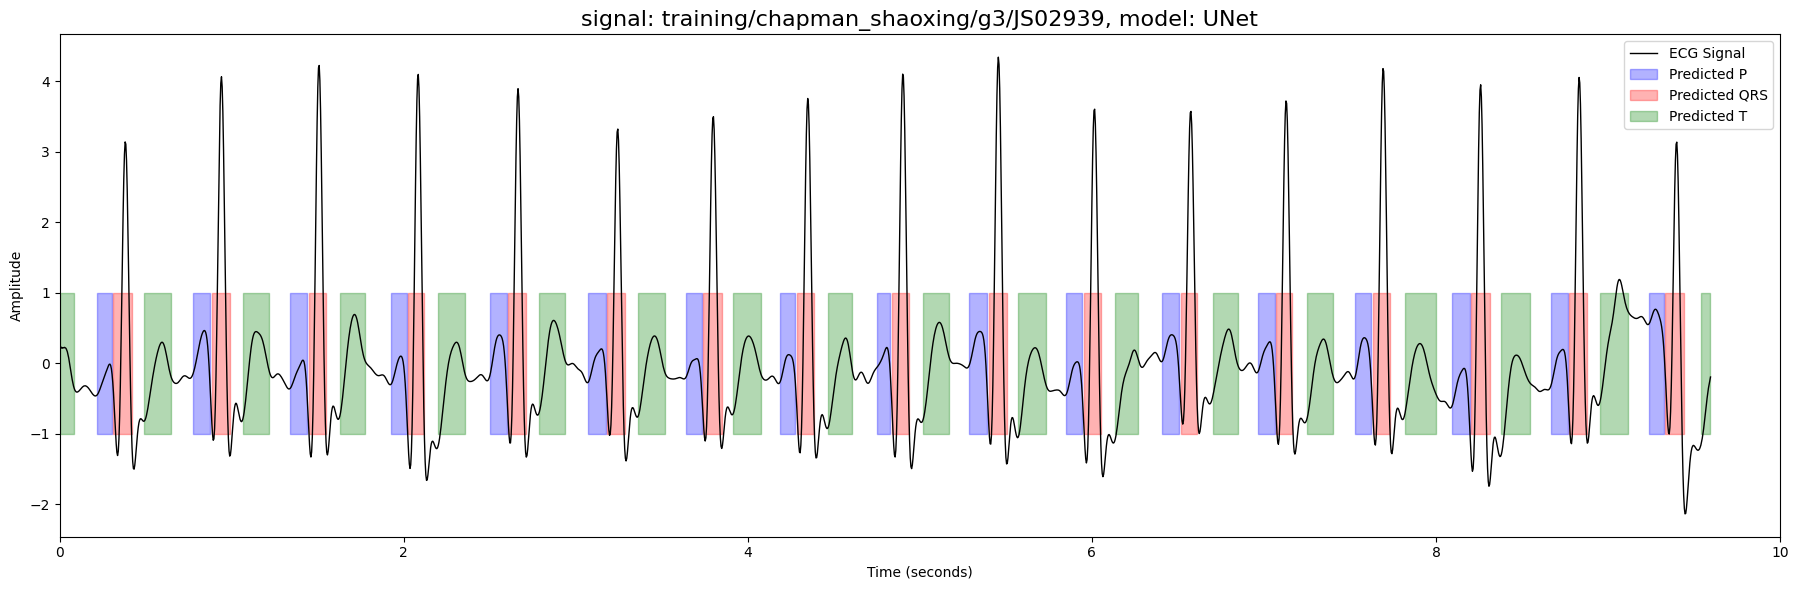

I0000 00:00:1749116603.024330      57 service.cc:148] XLA service 0x7c0528017d90 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749116603.025395      57 service.cc:156]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1749116604.060360      57 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


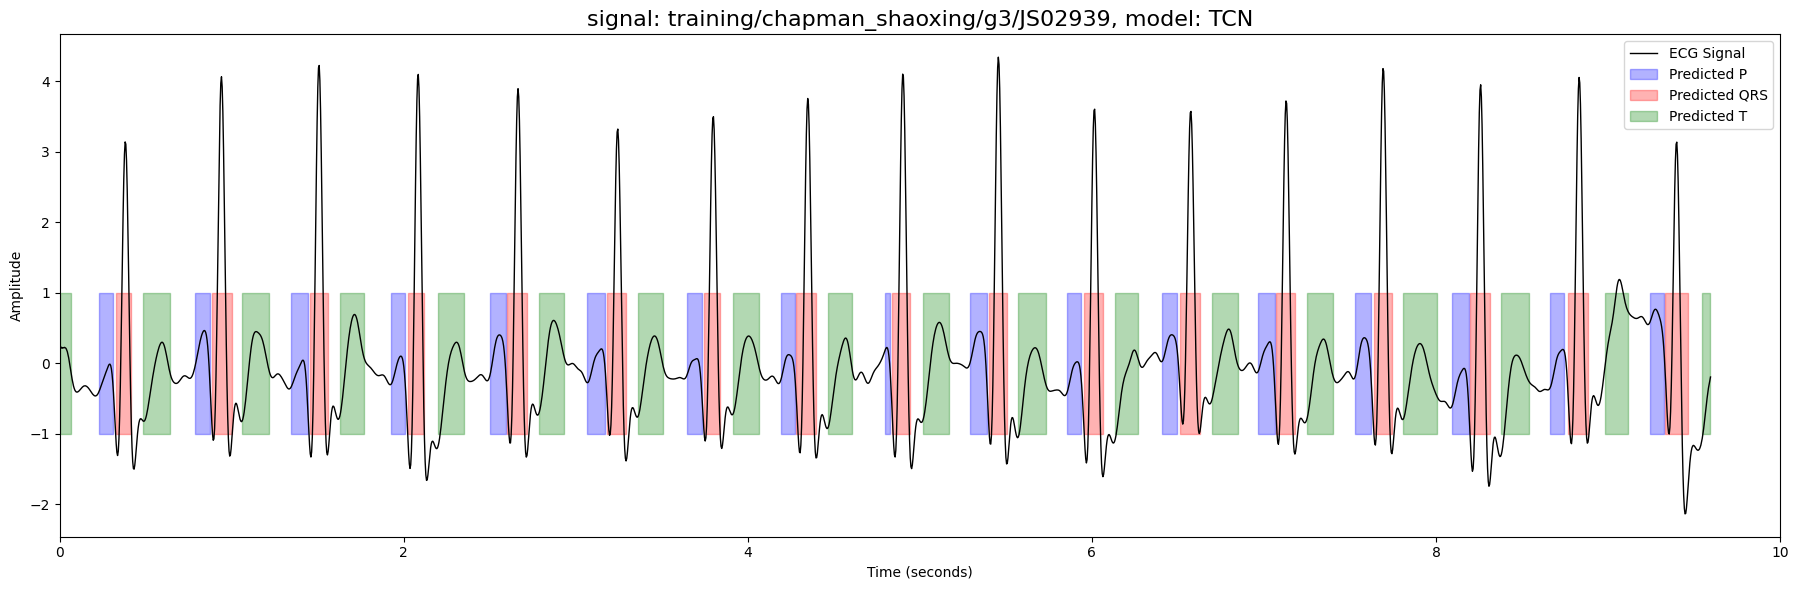

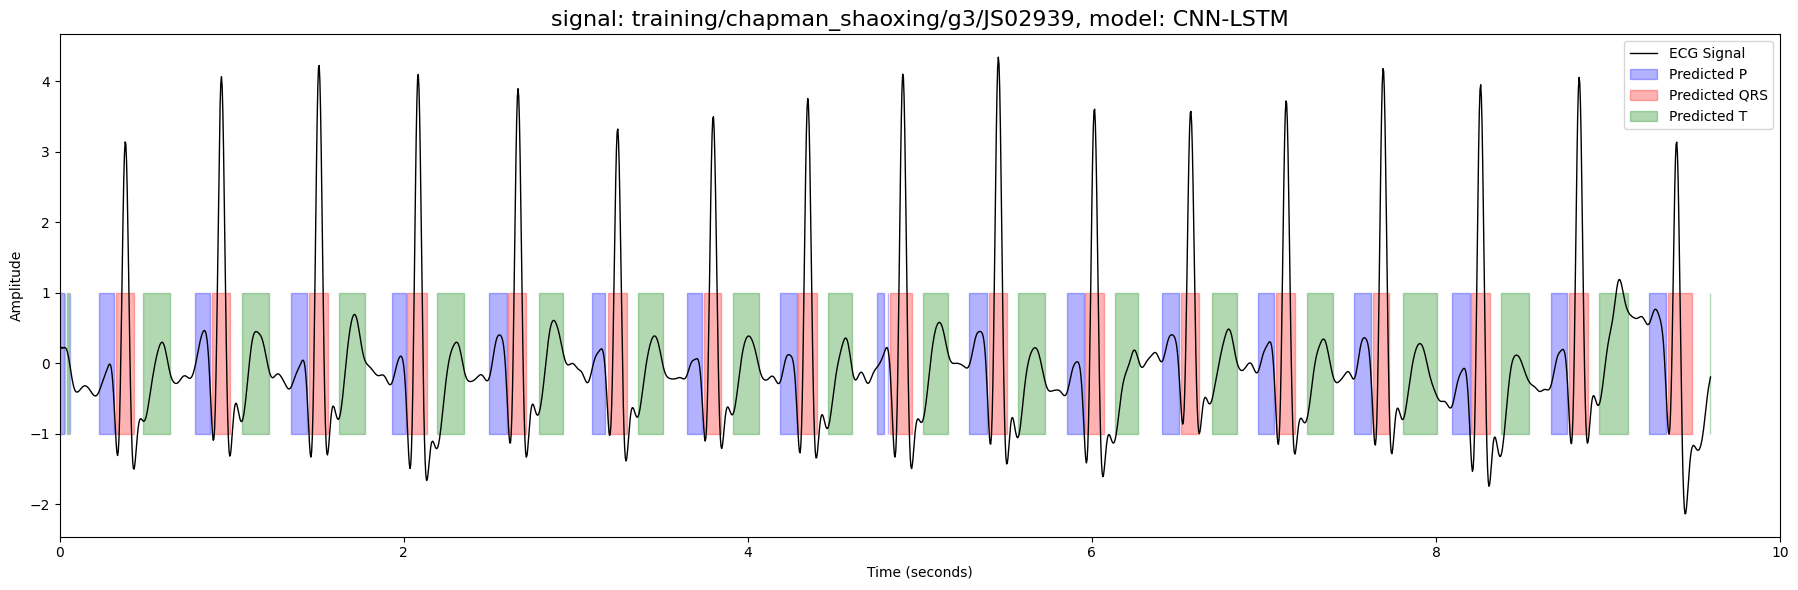

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------


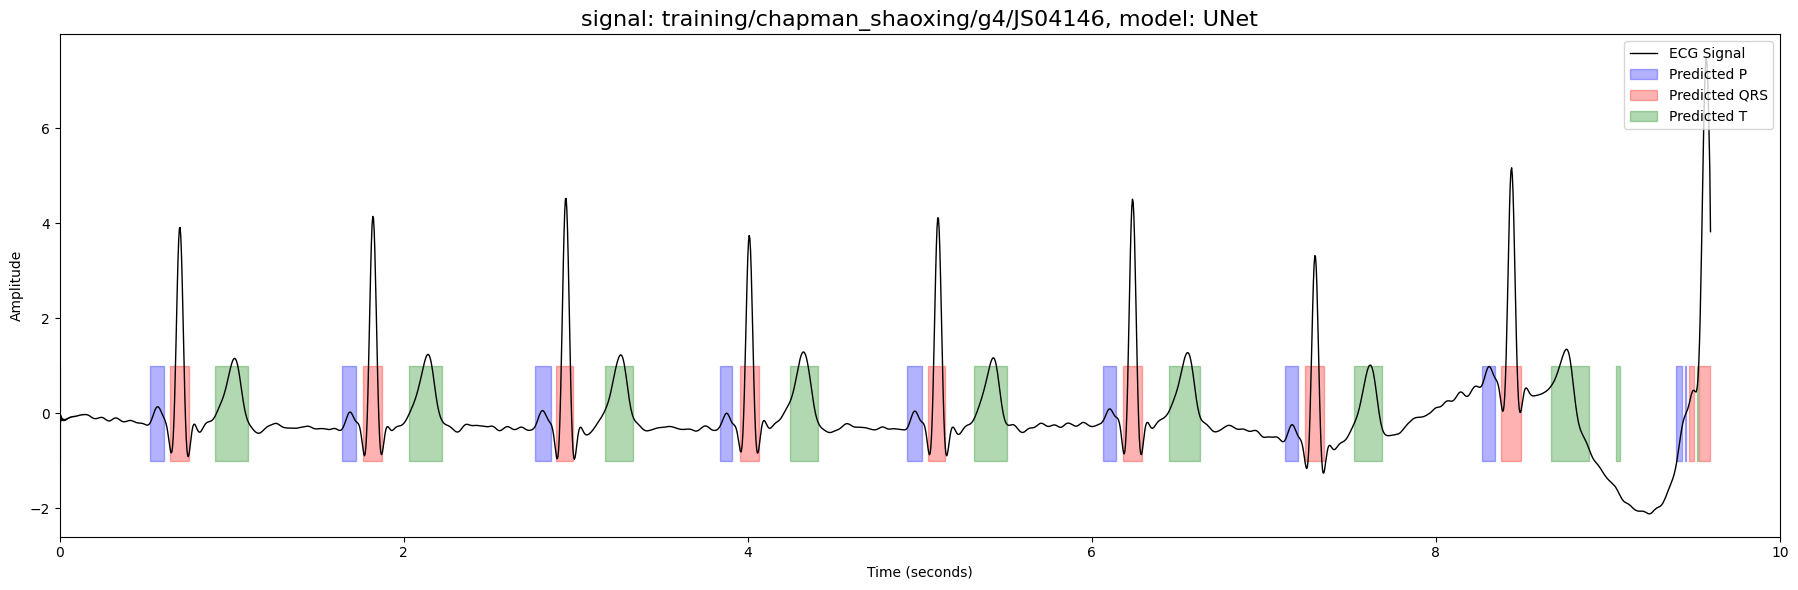

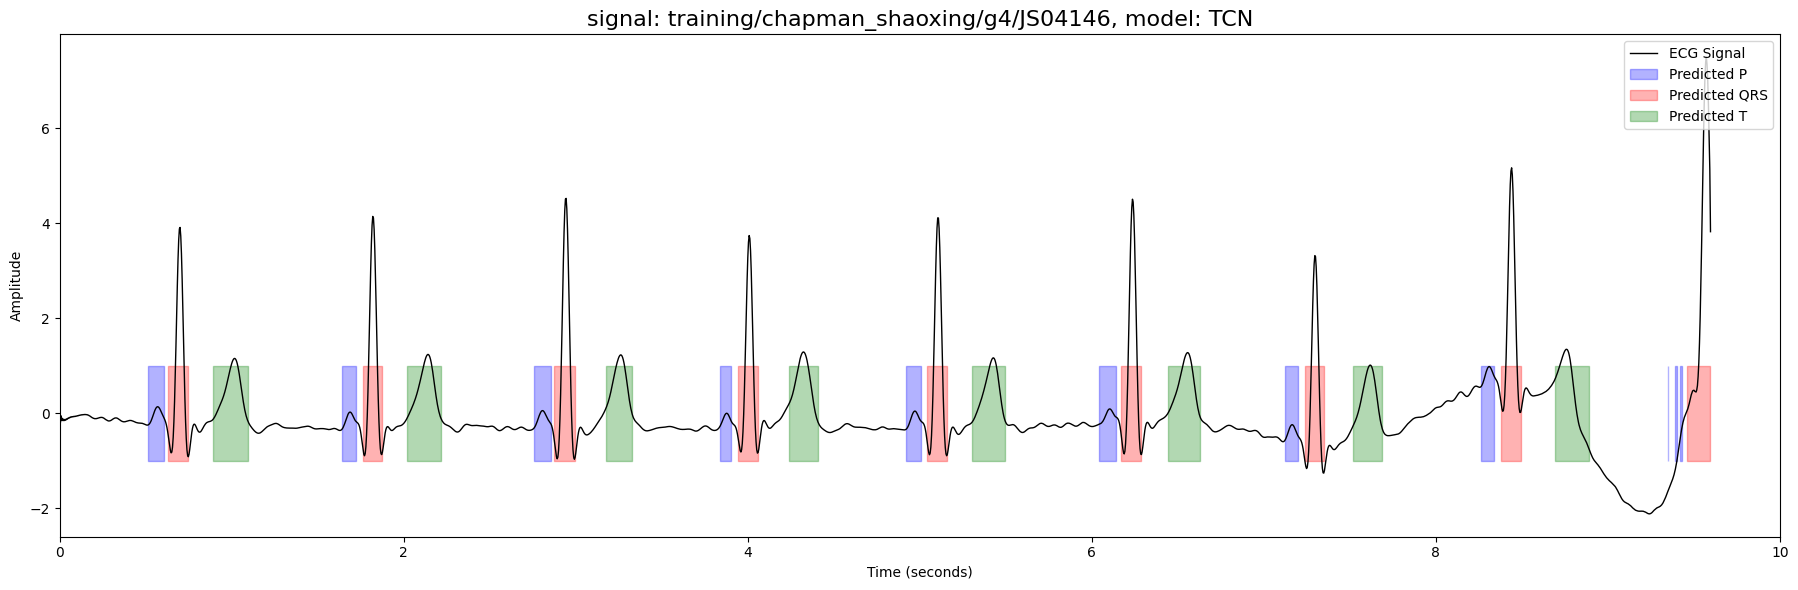

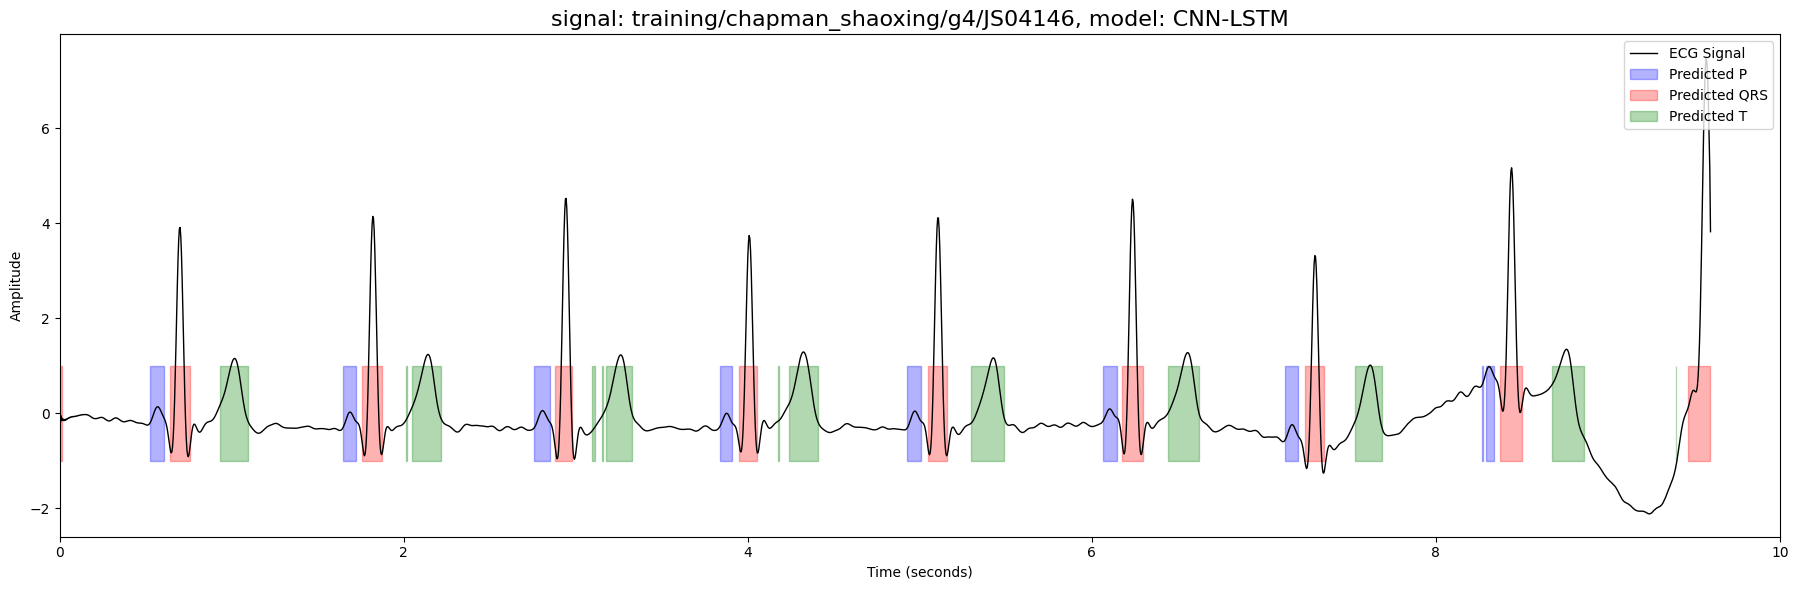

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
UNet_better


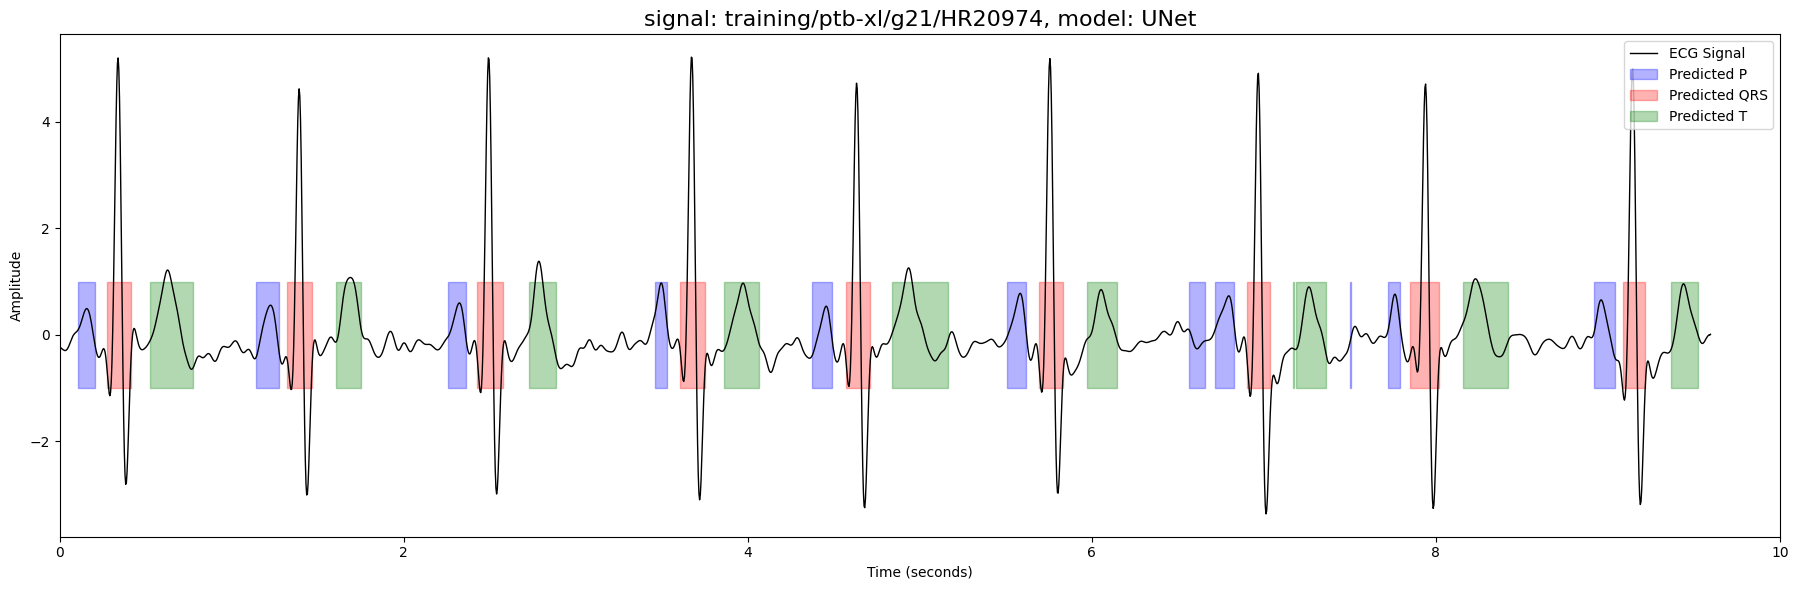

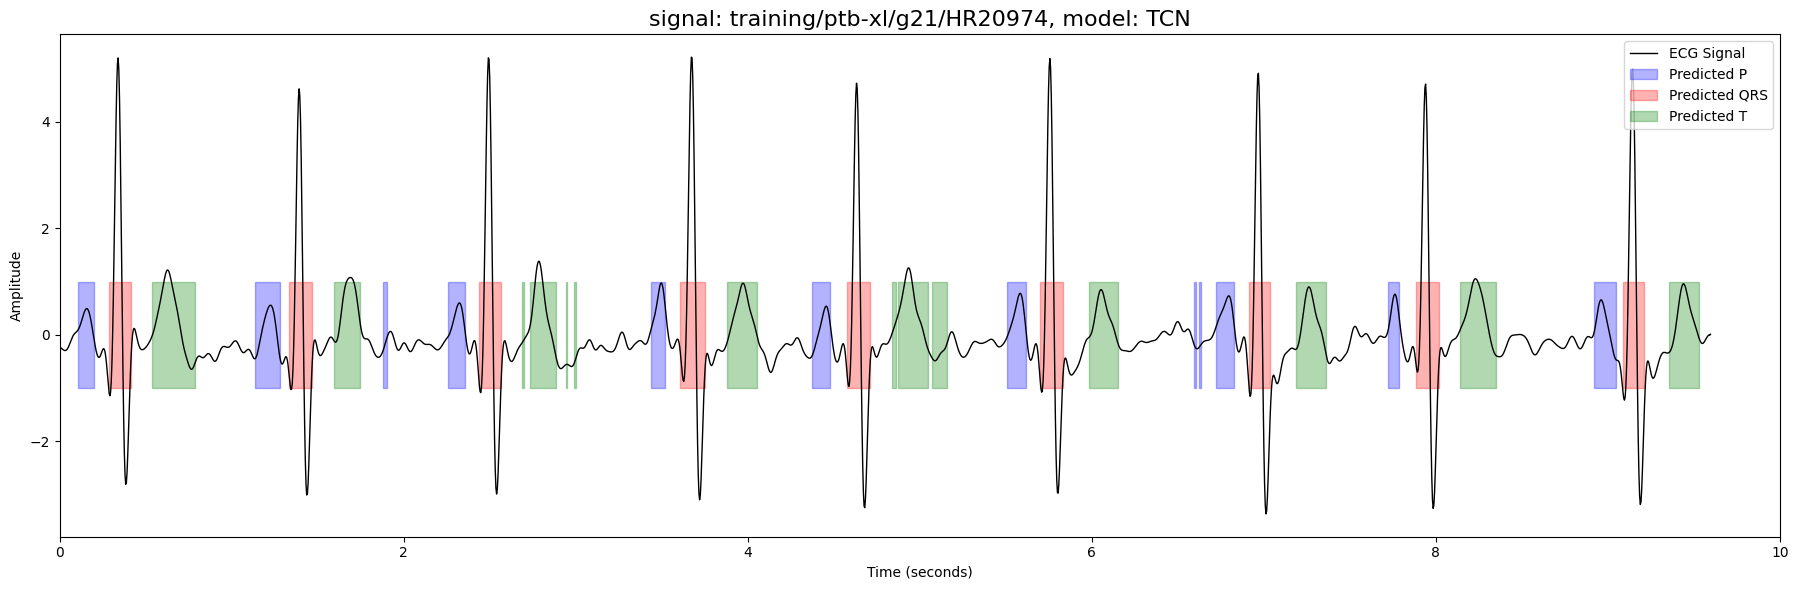

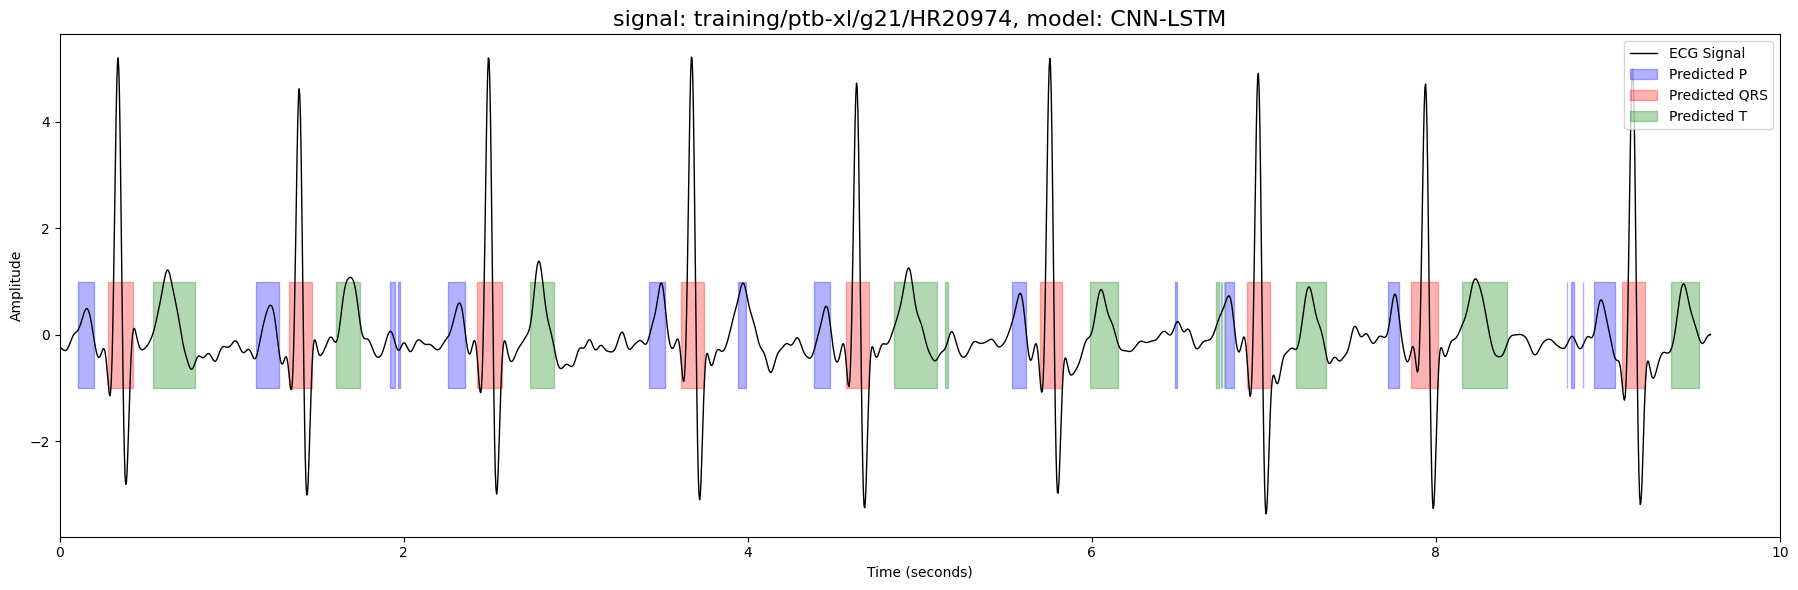

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------


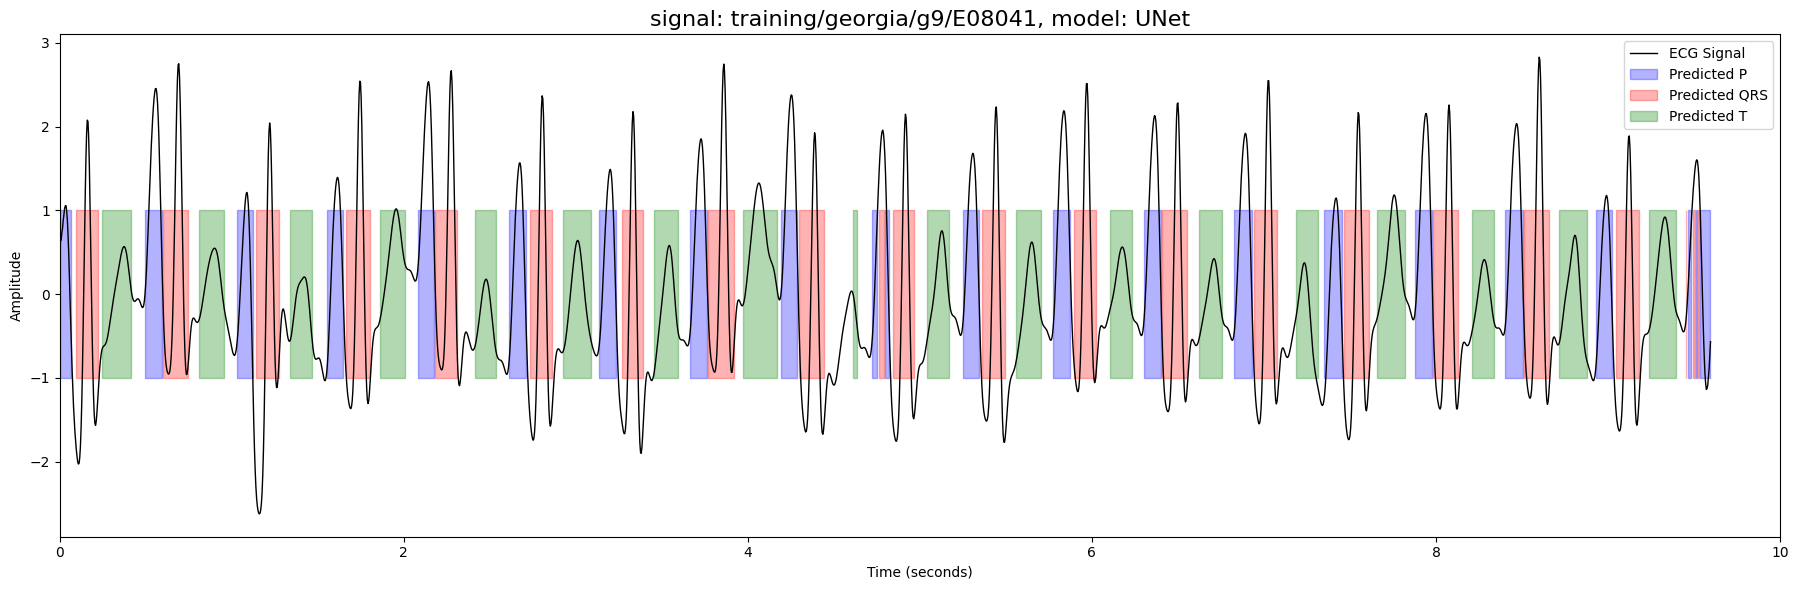

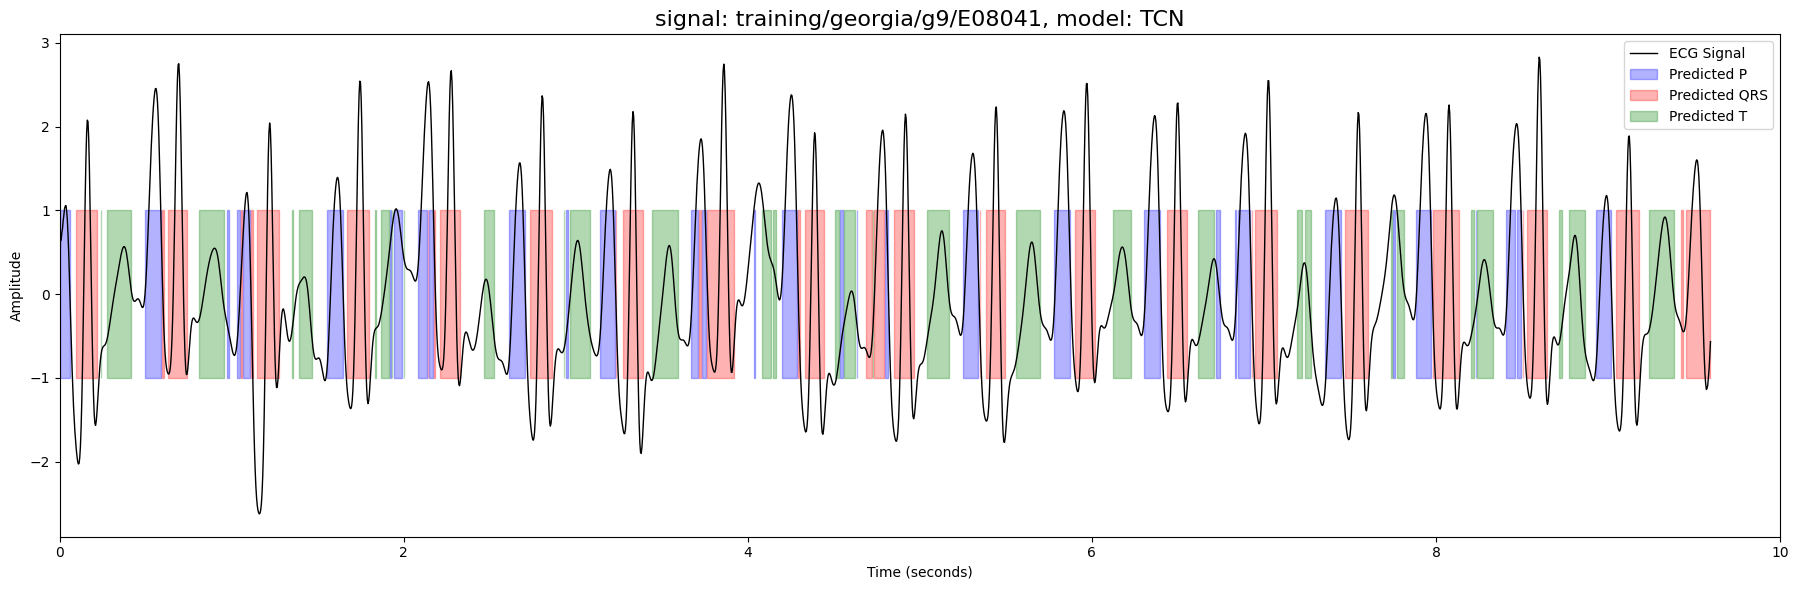

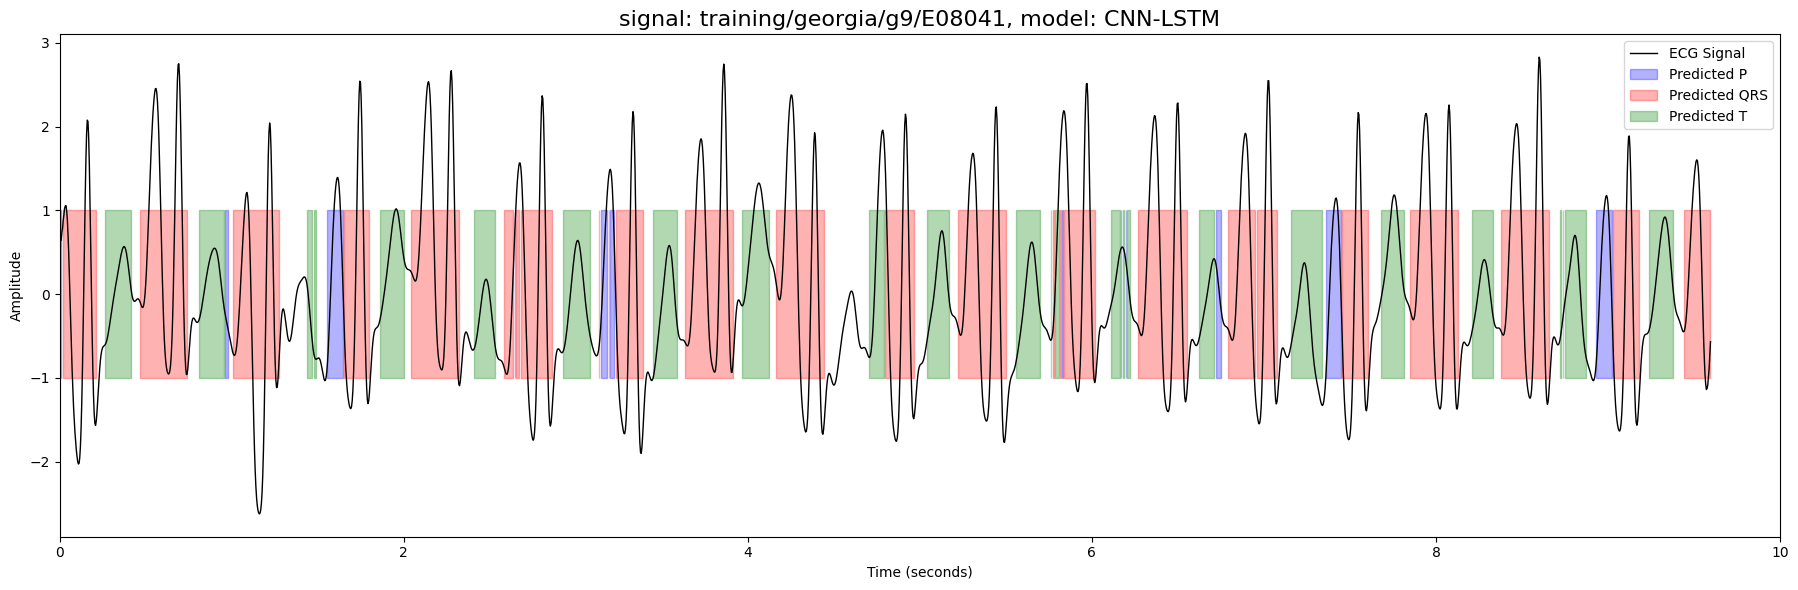

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------


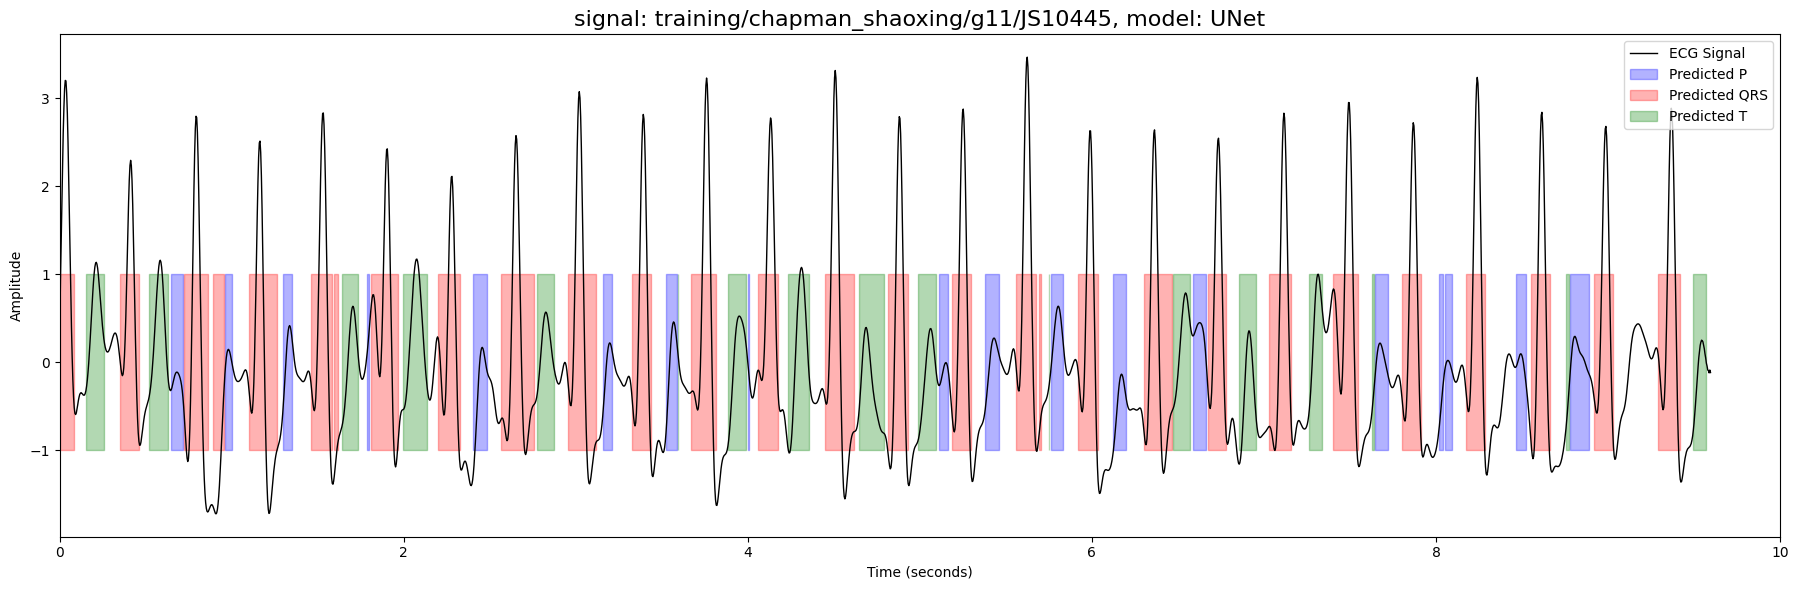

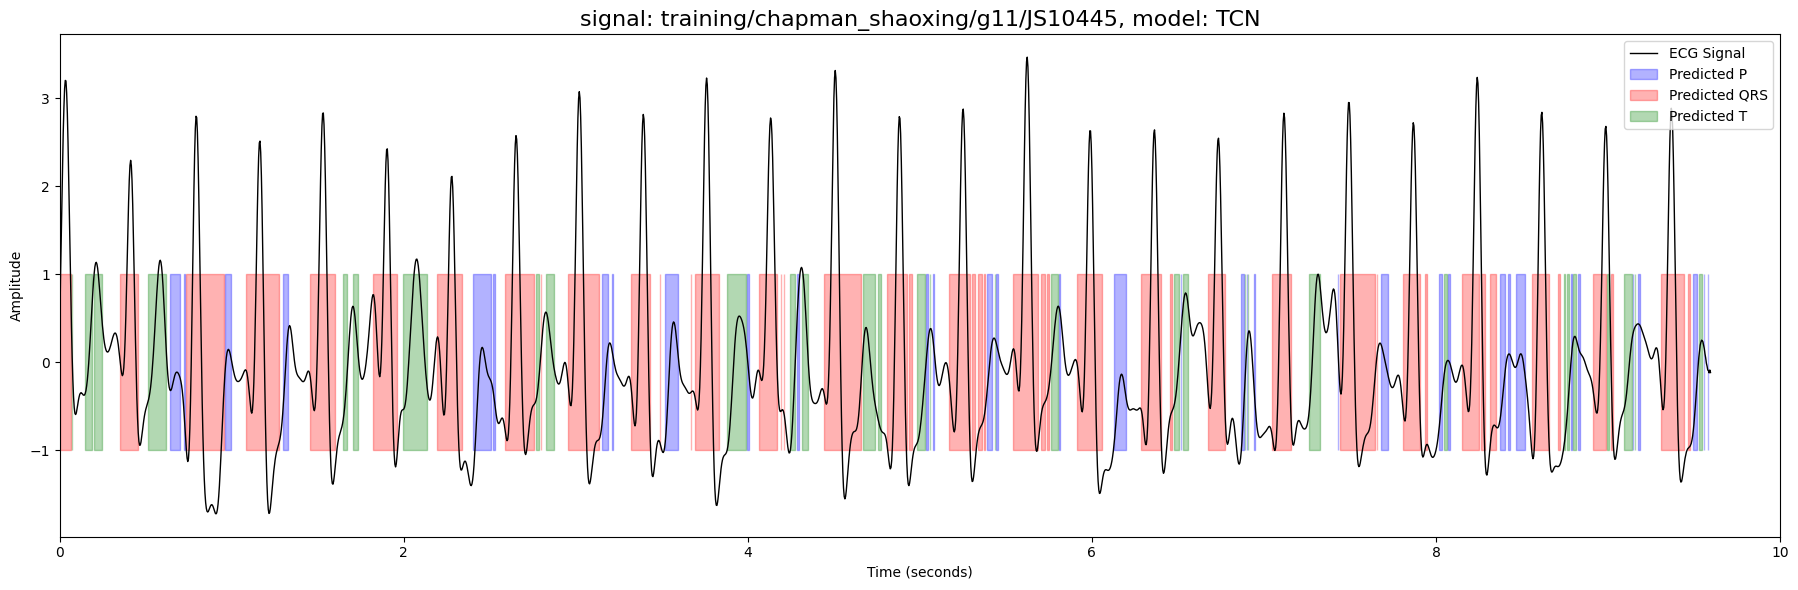

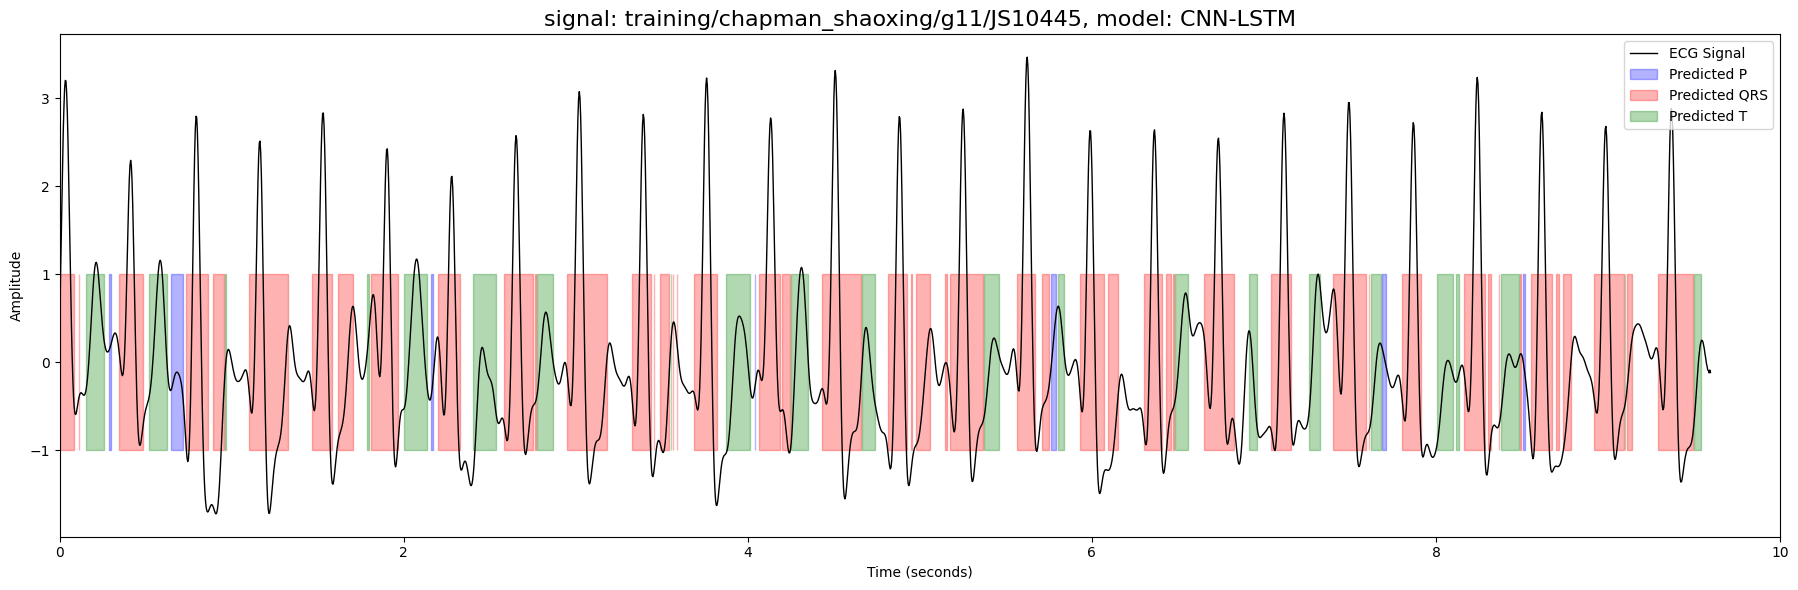

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------


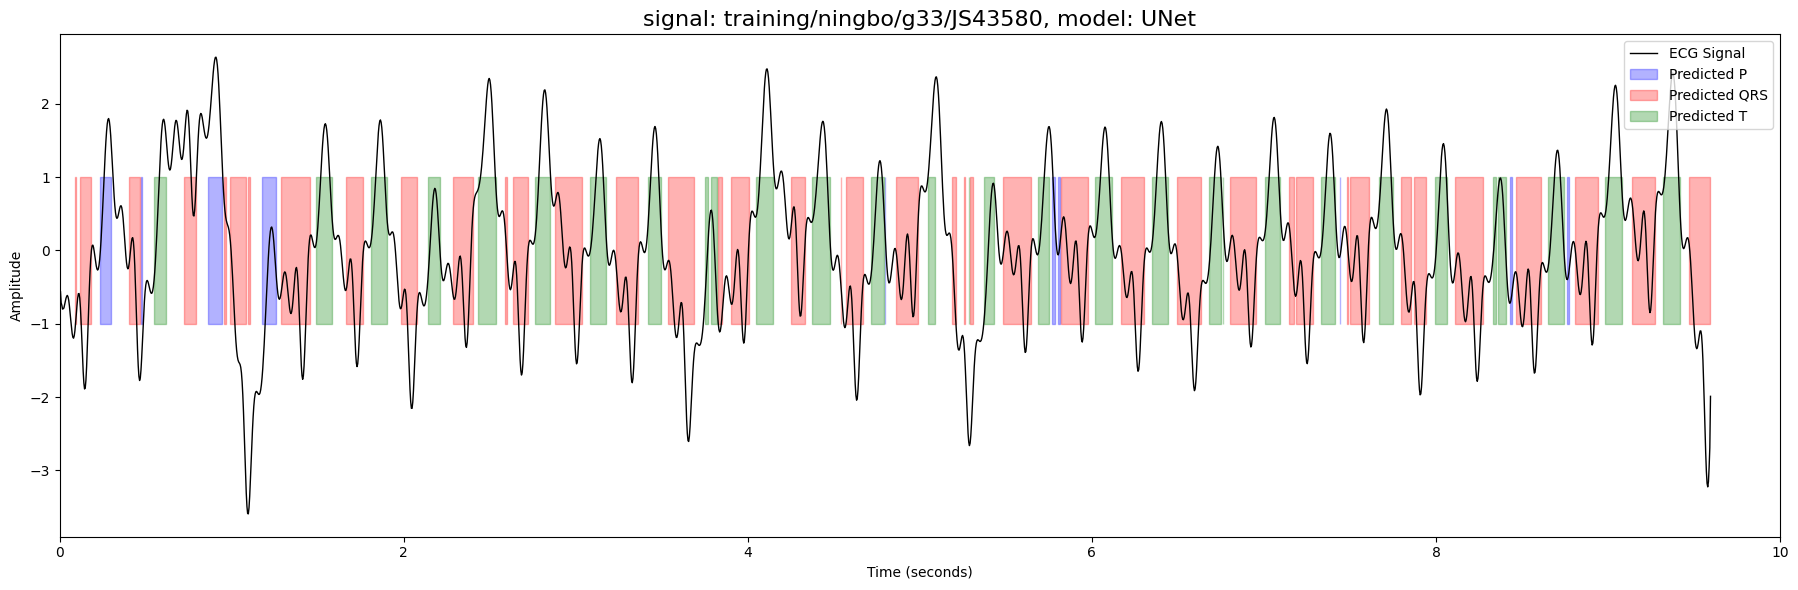

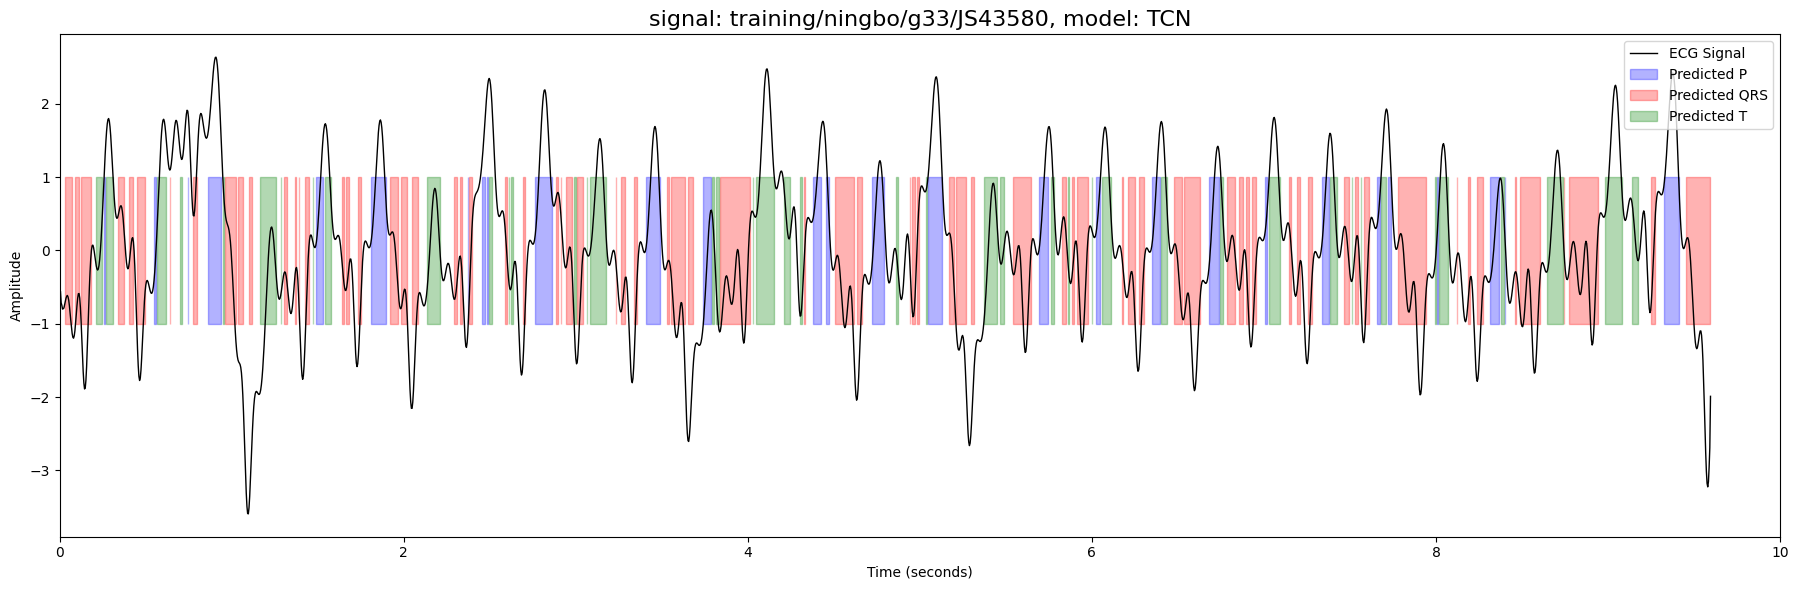

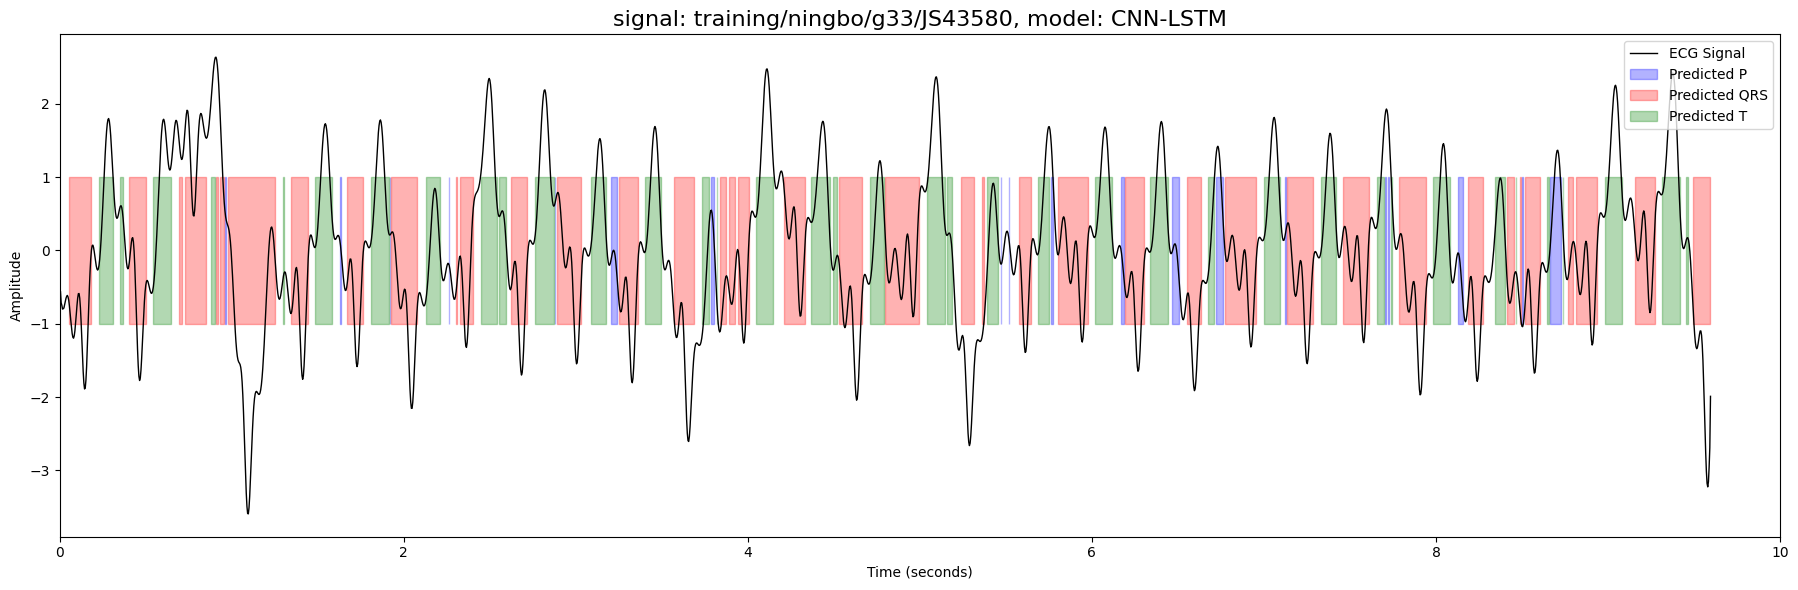

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
Random


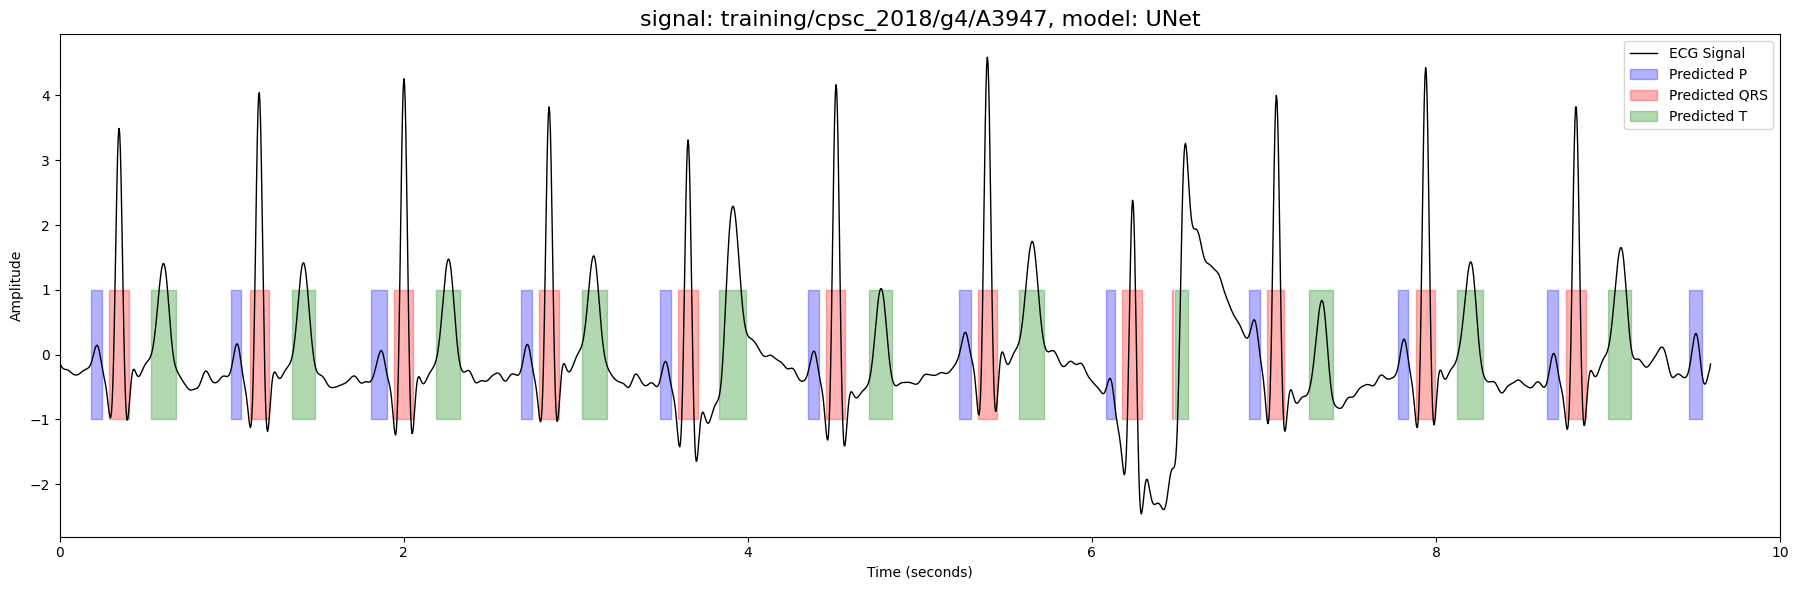

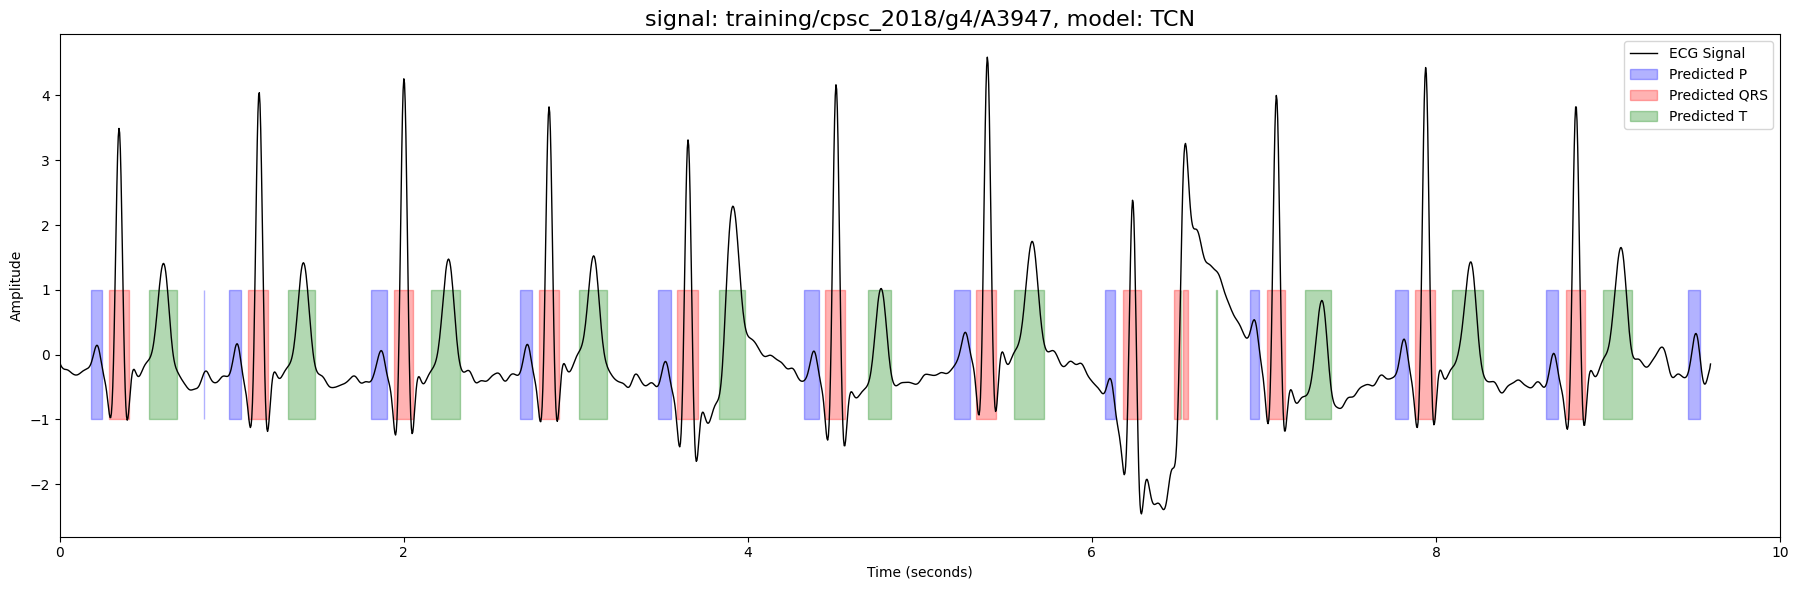

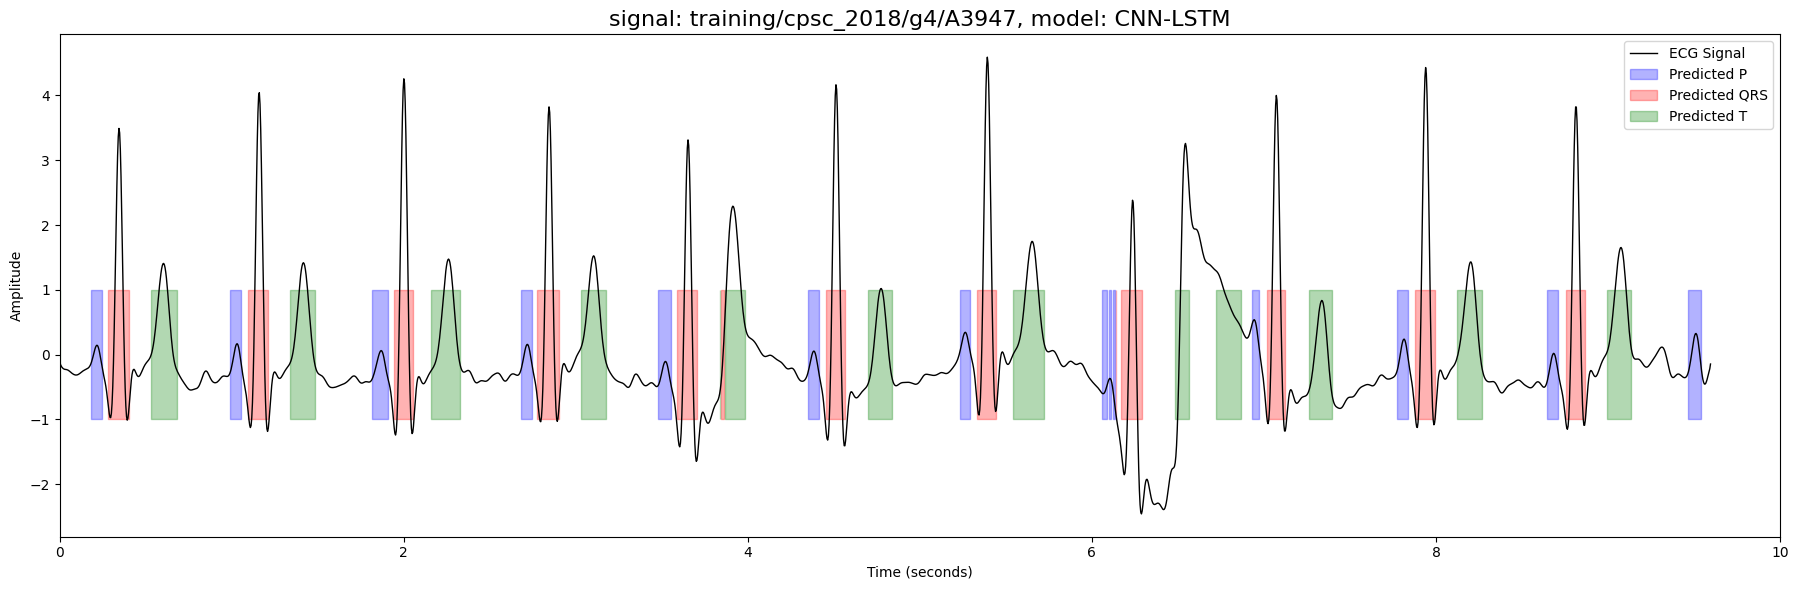

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------


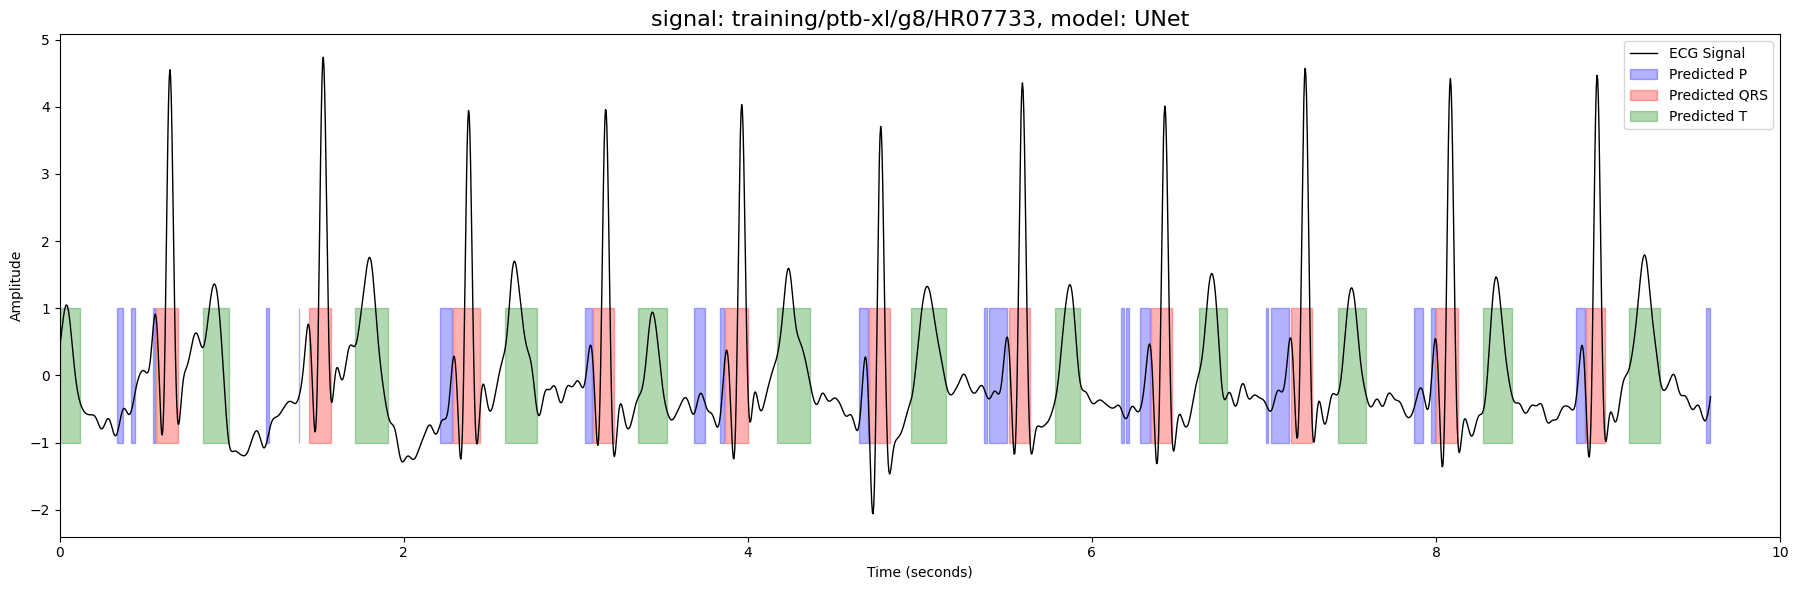

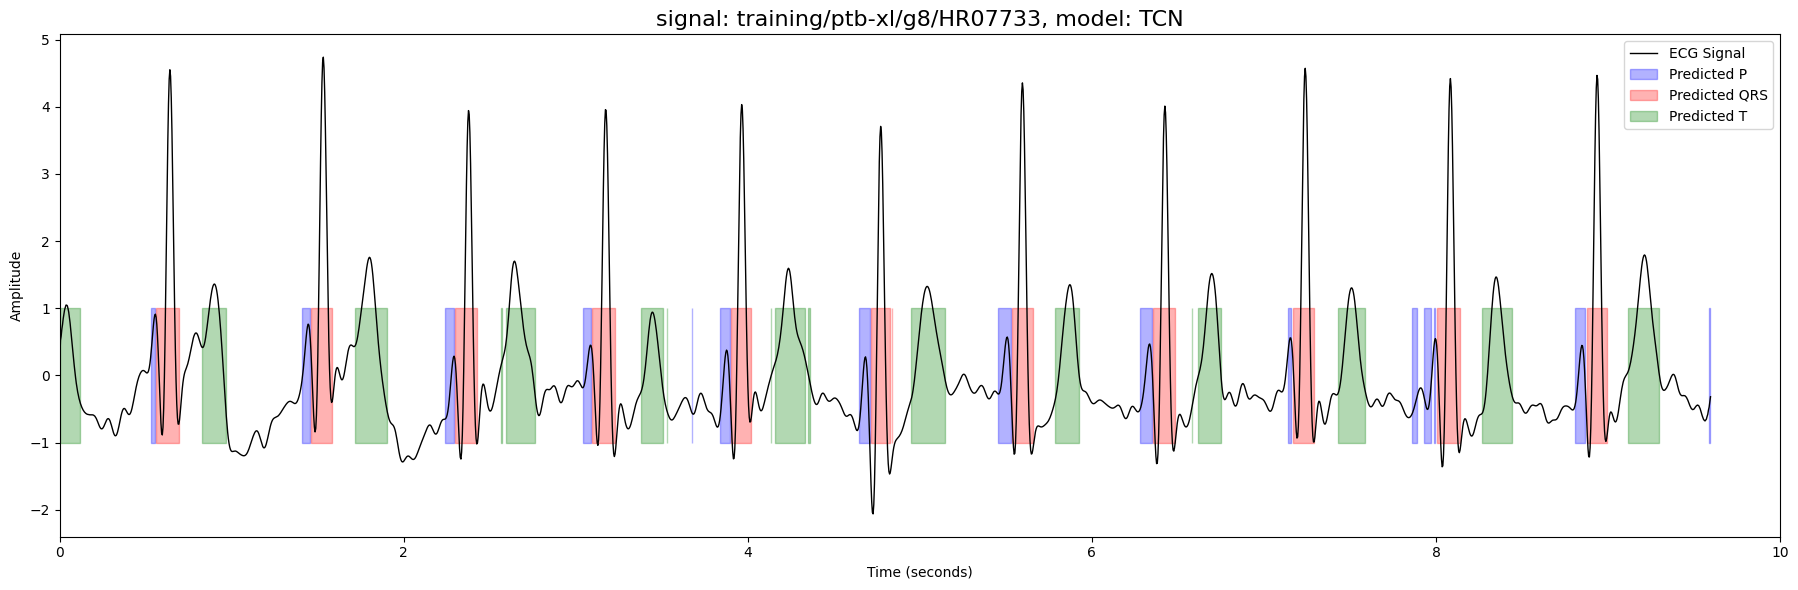

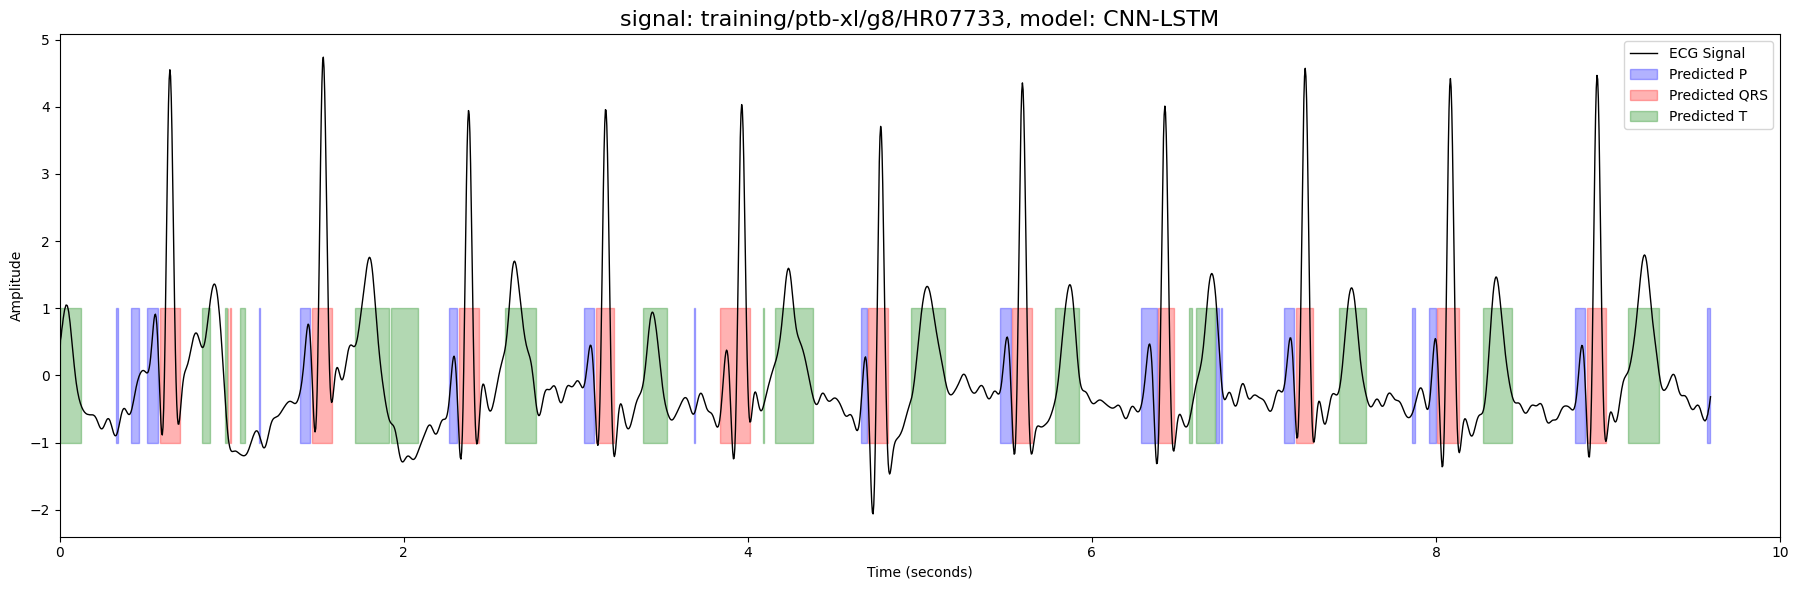

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------


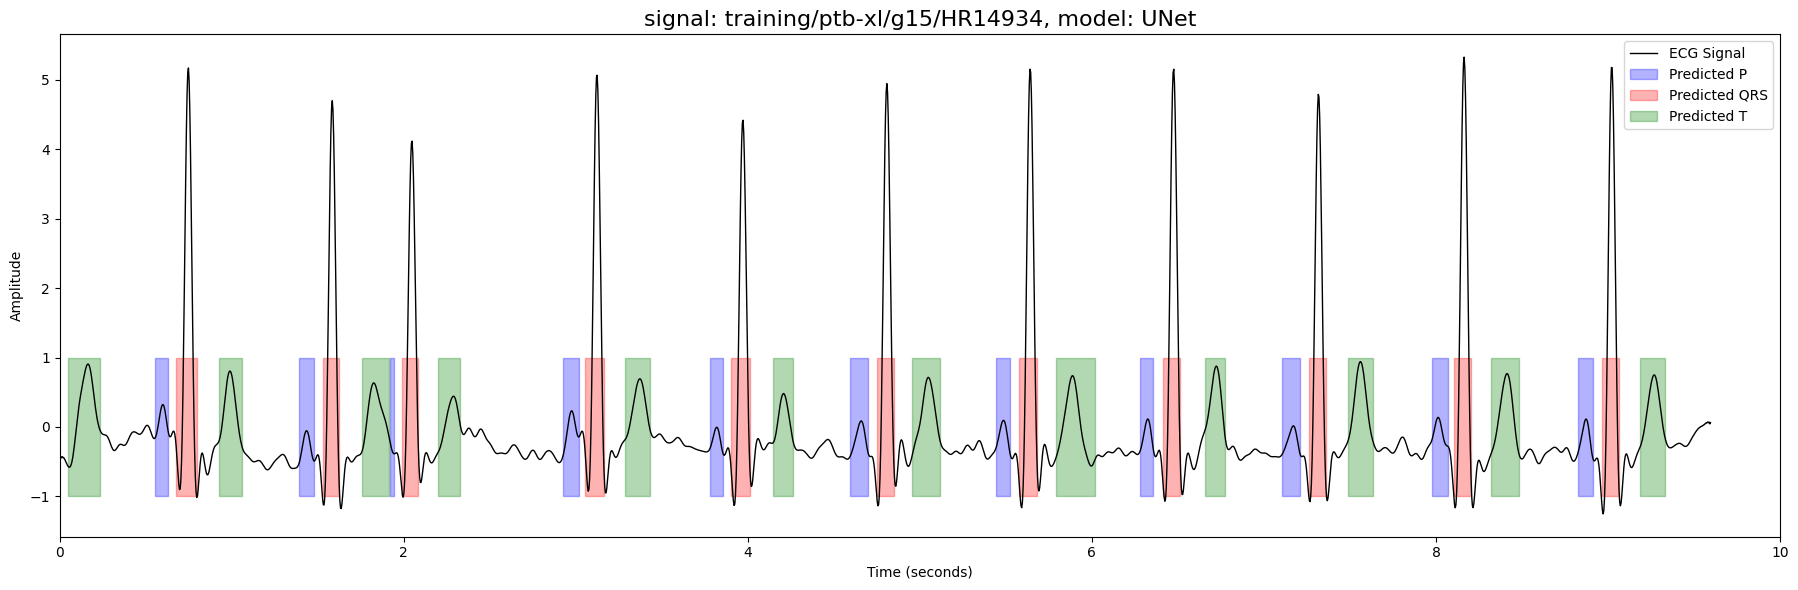

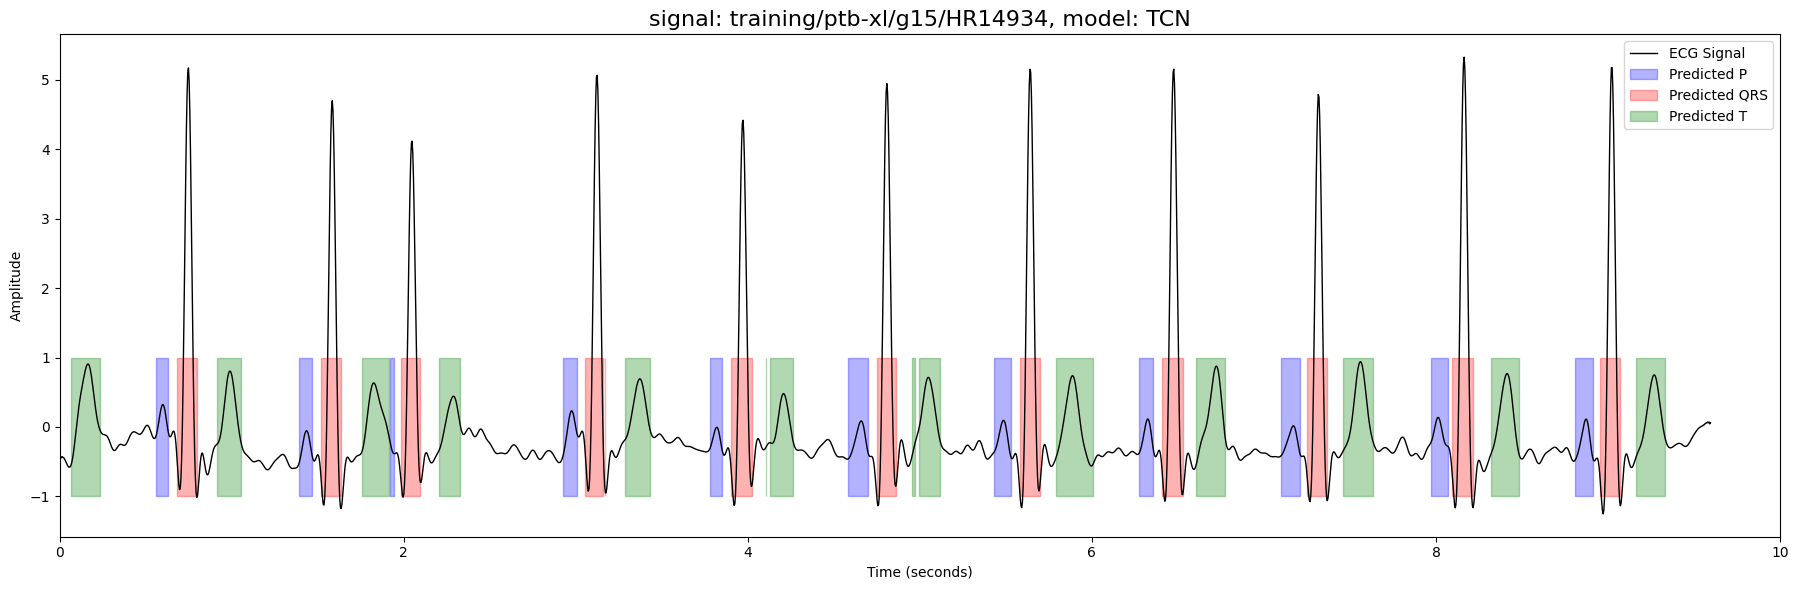

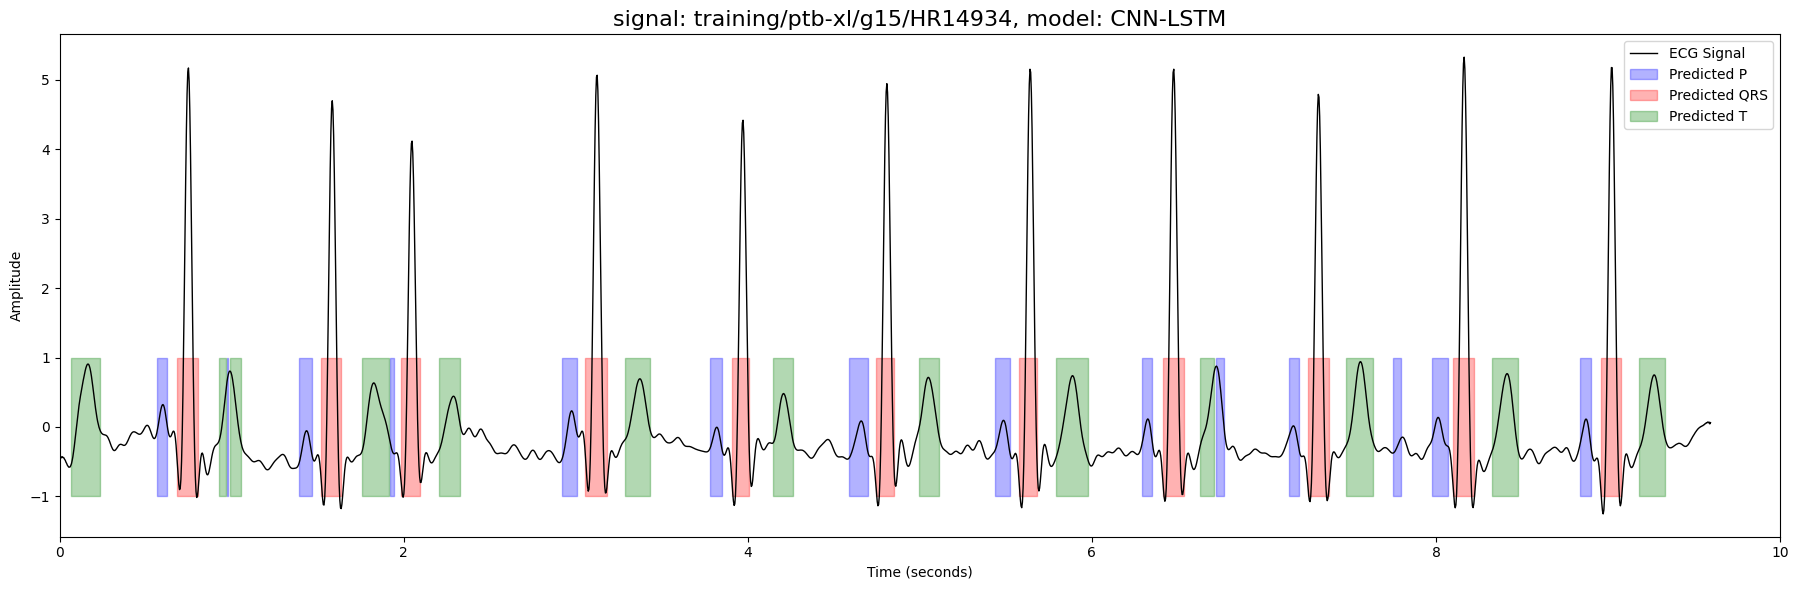

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------


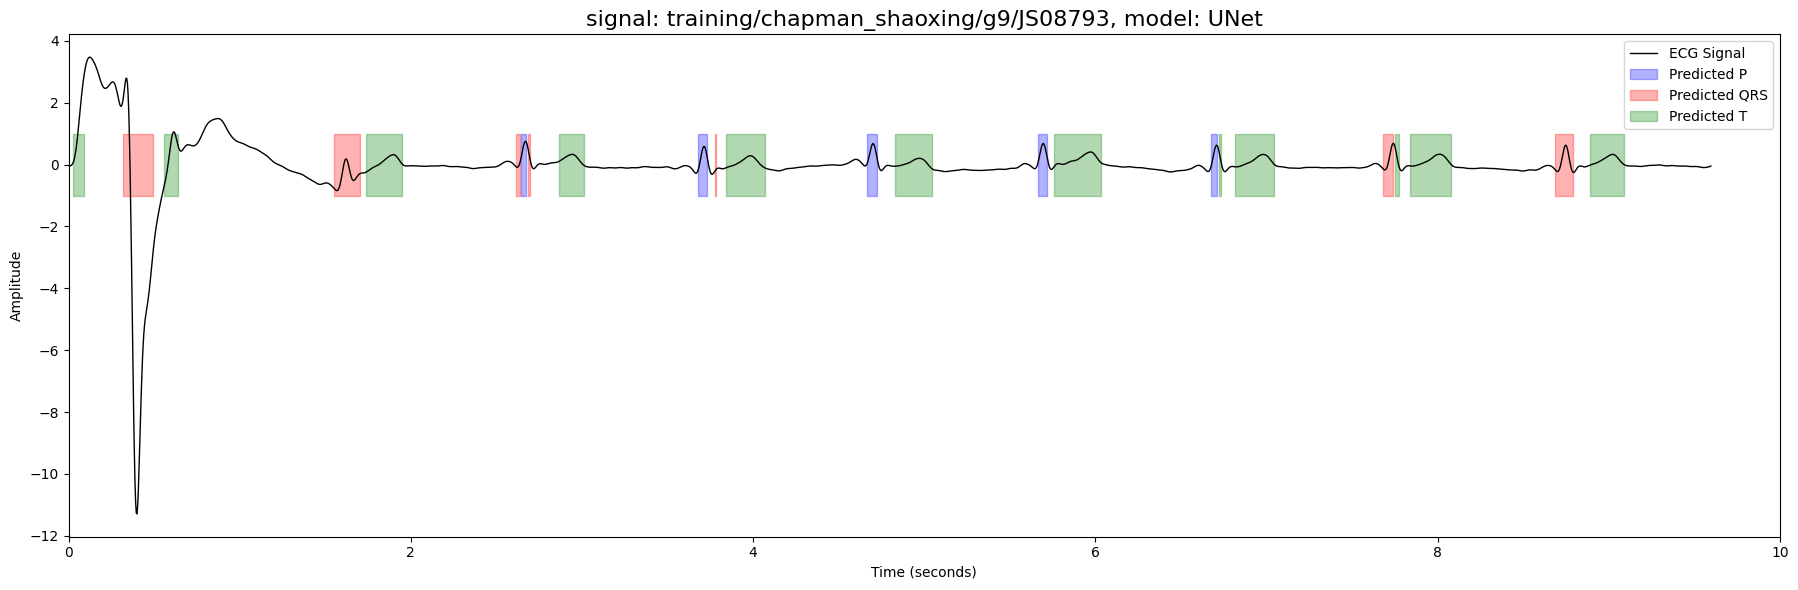

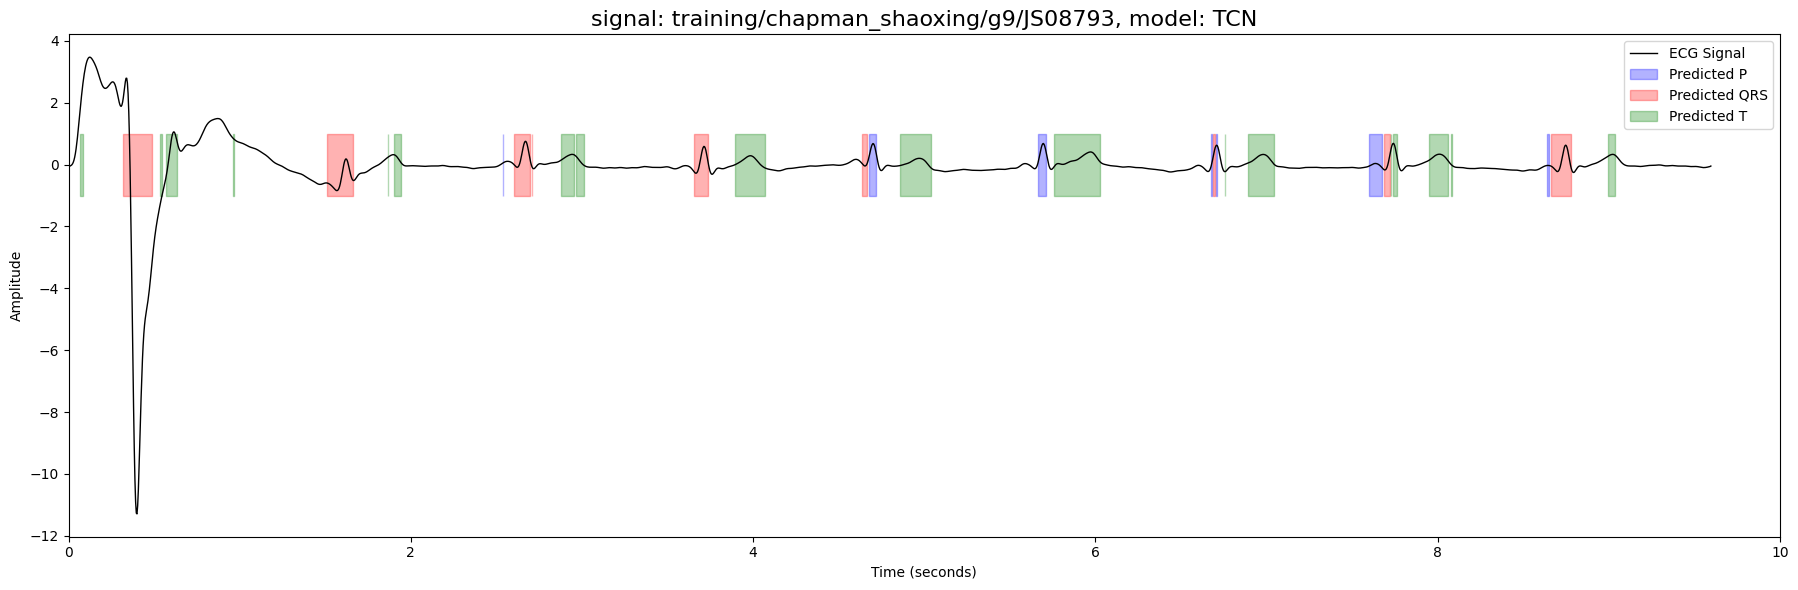

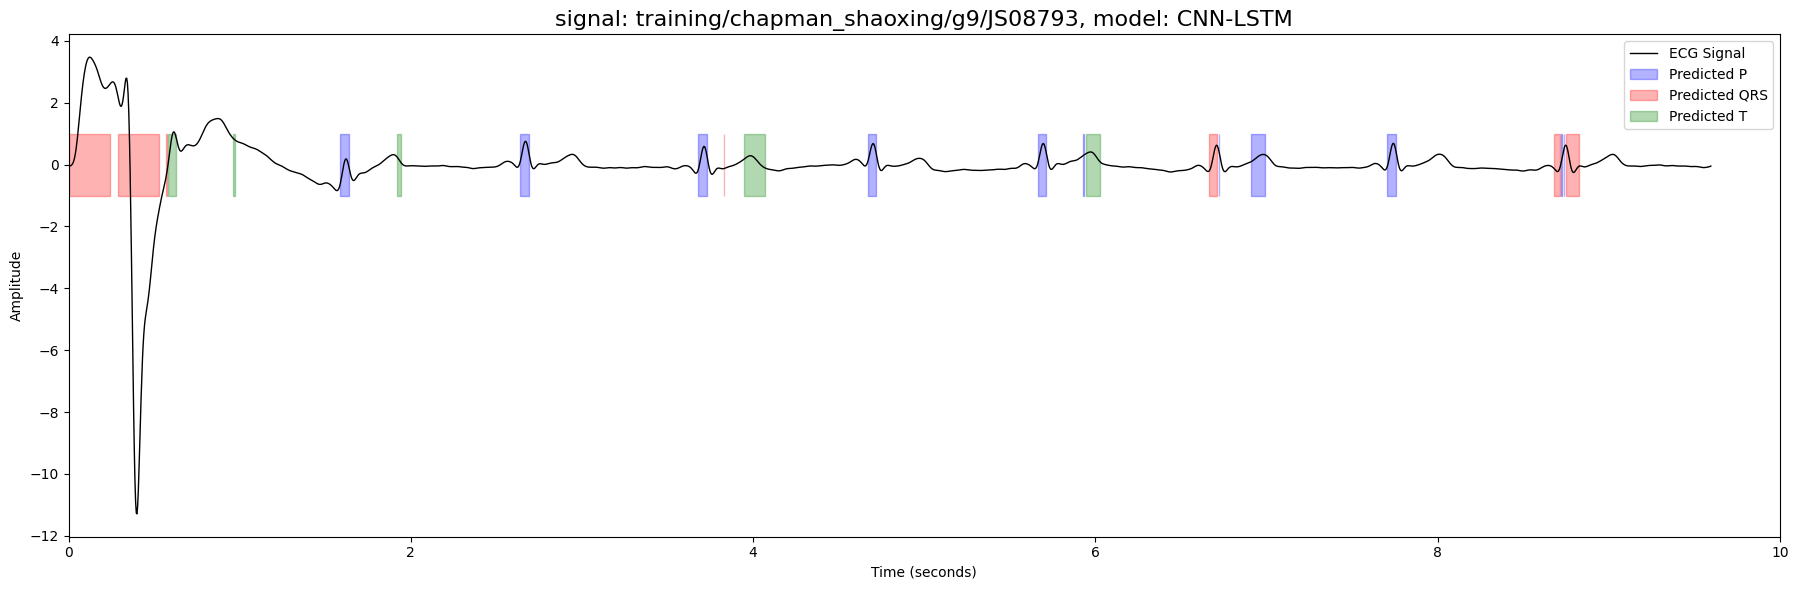

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------


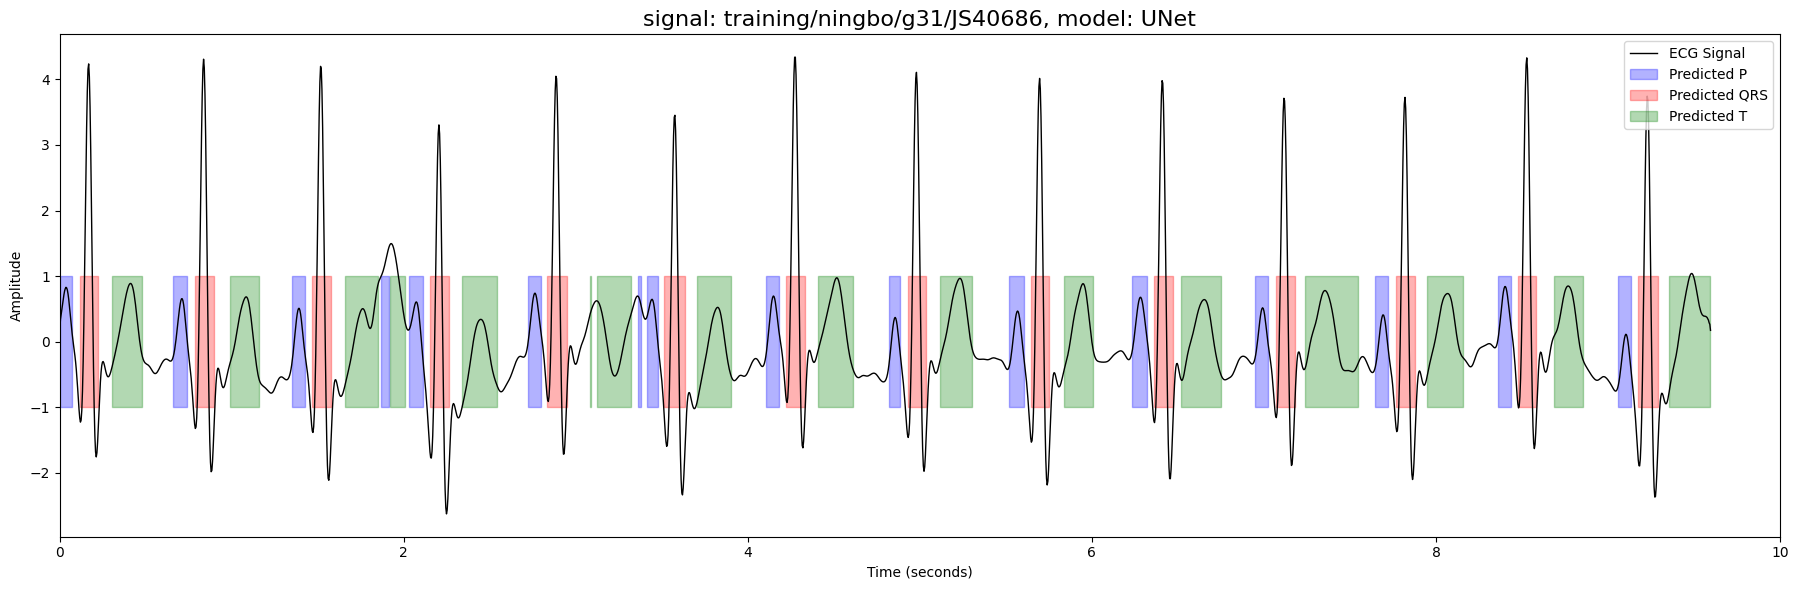

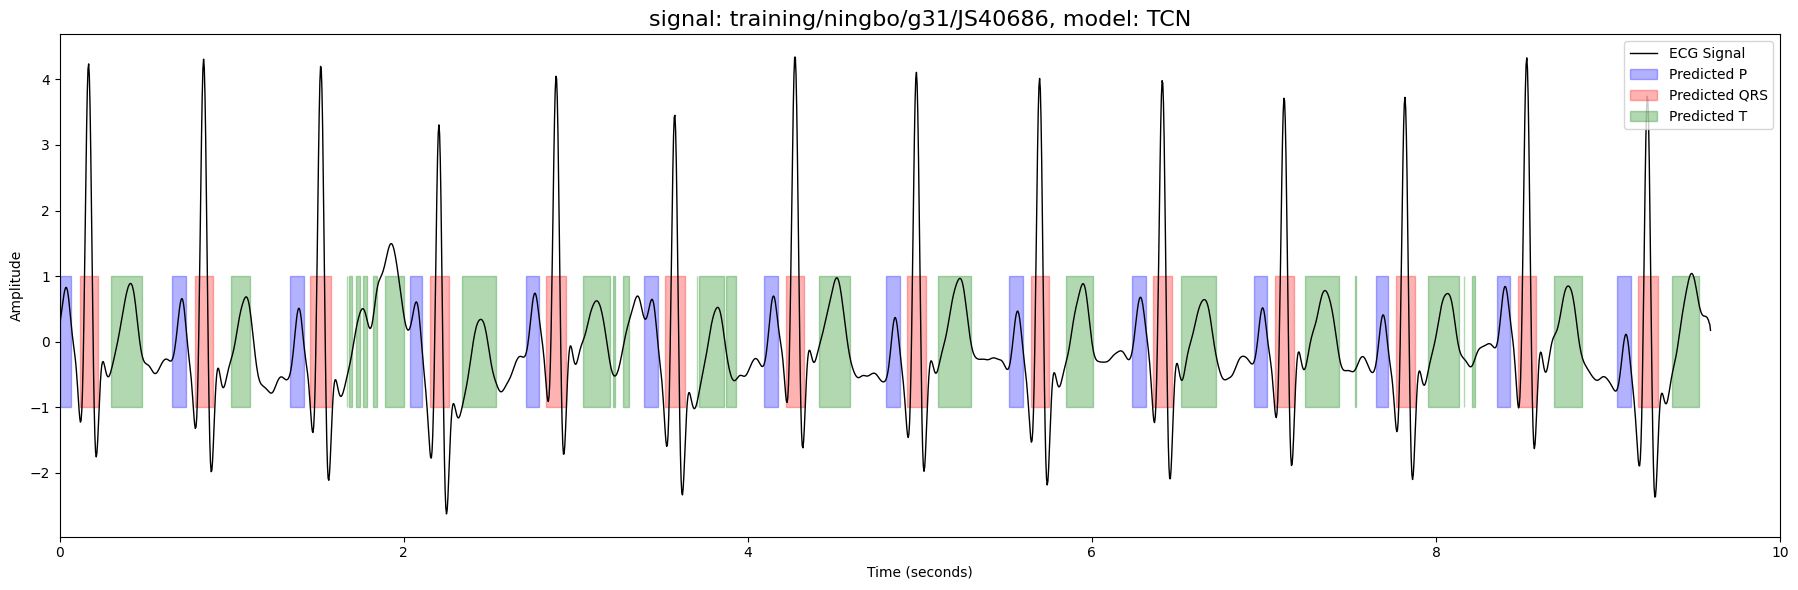

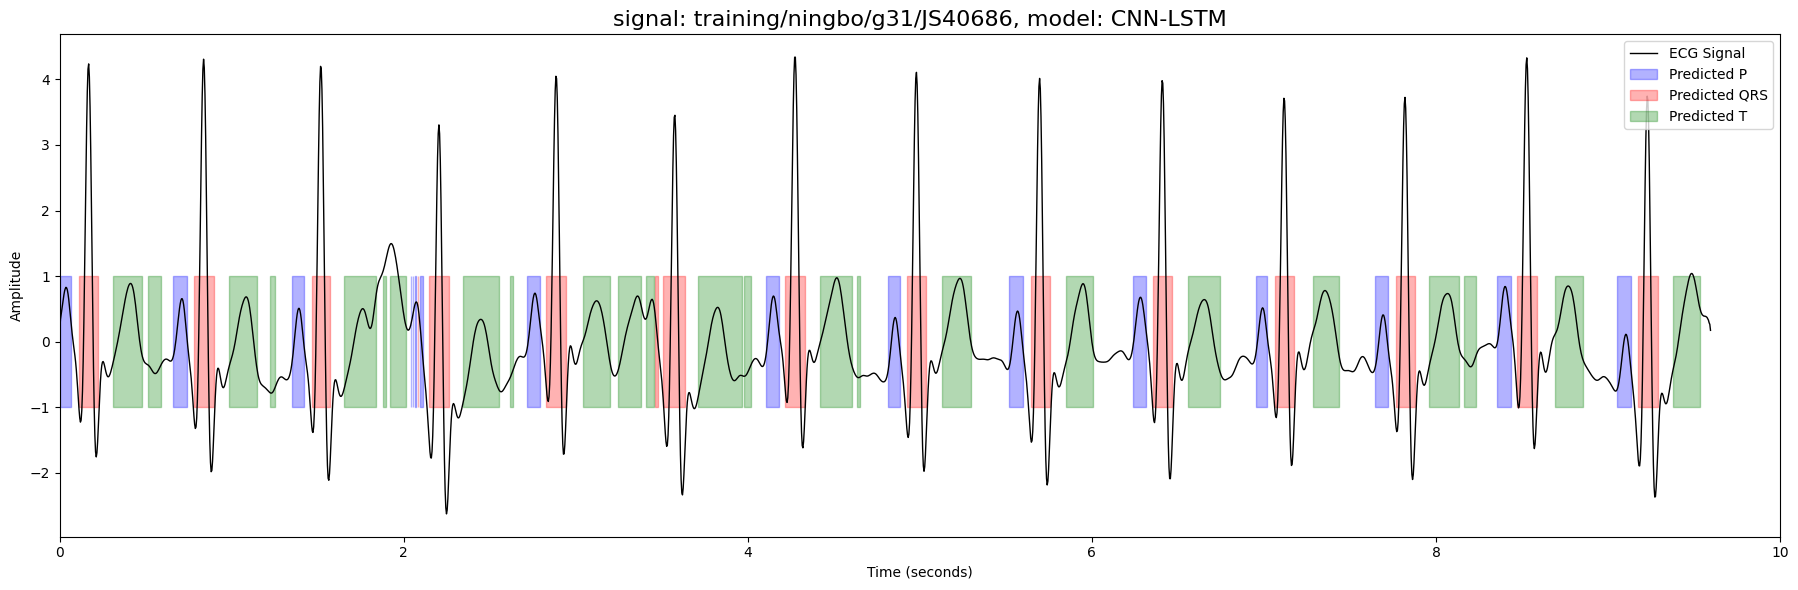

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------


In [16]:
UNet_better=[
'training/ptb-xl/g21/HR20974',
'training/georgia/g9/E08041',
'training/chapman_shaoxing/g11/JS10445',
'training/ningbo/g33/JS43580',
]
all_good=[
'training/chapman_shaoxing/g3/JS02939',
'training/chapman_shaoxing/g4/JS04146',
]

print("all_good")
for i in range(len(all_good)):
    compare_models(all_good[i])
print("UNet_better")
for i in range(len(UNet_better)):
    compare_models(UNet_better[i])
print("Random")
for i in range(len(random_records)):
    compare_models(random_records[i])